# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (urti), upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [285]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import OneHotEncoder
from datetime import date
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

In [286]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [287]:
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [288]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    a.Freq = a.Freq*1000
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count in 1000 patients')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [289]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [290]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

## 1- Data Preparation

In [291]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation.csv.gz')
data.shape

(200000, 79)

In [292]:
data.describe(include='all')

,deregistered_date,died_date,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,admitted_date,urti_date_1,urti_date_2,...,hemiplegia_comor,hiv_comor,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id
count,10000,20000,150000,20000,20000,20000,20000,60000,20000,20000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05
unique,1238,694,41,41,41,13,13,1238,1238,1238,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2020-08-05,2022-05-18,2019-12,2021-10,2020-10,2018-10,2018-08,2019-04-15,2019-09-18,2019-08-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,18,186,3850,548,526,1758,1720,76,33,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,9.995434e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,5.772812e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.999245e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.995335e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.499105e+06


### 1-2- Additional variables
#### 1-2-1- Calculating CHarlson Comorbidity Index
Based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [293]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')
# col18 = data.columns.get_loc('age')


for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    # if data.iat[idx, col4] == 1: # heart_failure_comor############################
    #     n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia#########################################
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma#########################################
    #    n=n+2

    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3

    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6

    # #age component
    # if data.iat[idx, col18] <= 40:
    #     n=n+0
    # if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
    #     n=n+1
    # if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
    #     n=n+2
    # if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
    #     n=n+3
    # if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
    #     n=n+4
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37088
1.0     36881
2.0     32937
3.0     24891
4.0     14936
6.0     12342
7.0     10064
5.0      8396
8.0      8113
9.0      5716
10.0     3338
11.0     1808
12.0     1414
13.0      803
14.0      532
15.0      326
16.0      209
17.0      121
18.0       47
19.0       24
20.0       10
21.0        4
Name: CCI, dtype: int64

#### 1-2-2- Calculating all meds except abs

In [294]:
#generate meds_noabs in the one month before
data['meds_nonabs'] = data['all_meds'] - data['antibacterial_brit']

# assign zero for any row with negative values which could be the case because of using dummy data and/or the inconsistency of the two codelists of all_meds and antibacterial_brit
data['meds_nonabs'][data['meds_nonabs'] < 0] = 0

data['meds_nonabs'].value_counts()
# data[['all_meds_one_month', 'antibacterial_brit_one_month', 'meds_nonabs']]

0    133063
2     22331
3     18789
1     17561
4      7070
5      1122
6        63
7         1
Name: meds_nonabs, dtype: int64

### 1-3- Handling variables with missing values
#### 1-3-1- Drop variables with many missing values
We drop colmns with more than 50 percent missing values as they may not be usable in the prediction model, nor they can be imputed properly.

In [295]:
# #dropping any variable with more than 50 percent missing values
# perc = 50.0
# data[['age', 'sex + CCI + bmi + antibacterial_brit + gp_count + imd', 'meds_nonabs', 'region']] = data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']].loc[:, data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']].isnull().mean() < perc]
# data.shape

In [296]:
# fig, ax = plt.subplots(figsize=(10, 8))
# sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs']].corr(), 
#             annot=True, fmt=".2f", annot_kws={"size":12},
#             vmin=-1.0, vmax=1.0)

# ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=90, fontsize=12)
# ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=0, fontsize=12)                        
# plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
# plt.show()

#### 1-3-2- Imputation of missing values
We impute variables with missing values that at most 50 pecent of their values are missing.

### 1-5- Polynomial featuring

In [297]:
# X = data[['age']]
# X.head()

In [298]:
# poly = PolynomialFeatures(degree=5, include_bias=False, interaction_only=False)
# # poly.fit_transform(X)
# poly_features = poly.fit_transform(X)
# poly_features = pd.DataFrame(poly_features)
# poly_features

## 2- Plots
### 2-1- Continuous factors

In [299]:
# fig, axes = plt.subplots(3,2, 
#                         figsize=(15, 15)
#                         )
# create_histplot('BMI', data['bmi'], axes[0,0])
# create_histplot('Age', data['age'], axes[0,1])
# create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
# create_histplot('Practice', data['practice'], axes[1,1])
# create_histplot('CCI', data['CCI'], axes[2,0])
# fig.delaxes(ax=axes[2,1])

# fig.suptitle('Risk Factors', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont.jpg')
# plt.show()

In [300]:
# p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
#                              ], 
#                 hue = 'admitted', # 'antibacterial_brit', 
# #                kind='reg', 
#                 #markers=["o", "s"], 
#                 diag_kind="kde",#"hist"
# #                plot_kws={#'line_kws':{'color':'red'}, 
#                 plot_kws={'alpha':0.3},
#                 height = 3)

# p.axes[0,2].set_xlim((0,20))
# p.axes[0,2].set_ylim((0,100))

# p.axes[1,1].set_xlim((0,75))
# p.axes[1,1].set_ylim((0,75))

# p.axes[2,0].set_xlim((0,100))
# p.axes[2,0].set_ylim((0,20))

# p.axes[0,3].set_xlim((0,20))
# p.axes[3,0].set_ylim((0,20))

# plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont_pairplot.jpg')
# plt.show()

### 2-2- Categorical factors

In [301]:
# fig, axes = plt.subplots(7,2,
#                         figsize=(15, 10)
#                         )
# create_lineplot(data, 'sex', 'Sex', 'Sex', axes[0,0])
# create_lineplot(data, 'age_cat', 'Age category', 'Age category', axes[0,1])
# create_lineplot(data, 'imd_imp', 'IMD', 'IMD', axes[1,0])
# create_lineplot(data, 'ethnicity_imp', 'Ethnicity', 'Ethnicity', axes[1,1])
# create_lineplot(data, 'smoking_status_imp', 'Smoking status', 'Smoking status', axes[2,0])
# create_lineplot(data, 'bmi_imp_cat', 'BMI', 'BMI', axes[2,1])
# create_lineplot(data, 'CCI_cat', 'CCI', 'CCI', axes[1,0])
# create_lineplot(data, 'gp_count_imp_cat', 'GP consultation', 'GP consultation', axes[3,1])
# create_lineplot(data, 'region', 'Region', 'Region', axes[4,0])
# create_lineplot(data, 'flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
# create_lineplot(data, 'antibacterial_brit_imp', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data, 'msoa', 'msoa', 'MSOA', axes[5,1])
# create_lineplot(data, 'meds_nonabs', 'Medicines excpet antibacterials', 'Medicines excpet antibacterials', axes[6,0])
# fig.delaxes(ax=axes[6,1])

# fig.suptitle('Risk Factors', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat.jpg')
# plt.show()

## 3- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 3-1- URTI

#### URTI-1

In [302]:
data_urti_1 = data[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'gp_count', 'imd', 'ethnicity', 
                    'antibacterial_brit', 'region', 'hx_hosp', 'CCI', 'meds_nonabs', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_1', 'gp_cons_urti_ab_1',
                    'urti_date_1', 'incdt_urti_date_1', 'admitted_urti_date_1', 'sgss_gp_cov_urti_date_1']]

data_urti_1 = data_urti_1[data_urti_1['urti_date_1'].notnull()]

data_urti_1.shape

(20000, 22)

In [303]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_1
data_urti_1 = data_urti_1[data_urti_1['sgss_gp_cov_urti_date_1'] == 0]
data_urti_1.shape

(18016, 22)

In [304]:
data_urti_1.columns

Index(['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi',
       'gp_count', 'imd', 'ethnicity', 'antibacterial_brit', 'region',
       'hx_hosp', 'CCI', 'meds_nonabs', 'died_date', 'deregistered_date',
       'gp_cons_urti_1', 'gp_cons_urti_ab_1', 'urti_date_1',
       'incdt_urti_date_1', 'admitted_urti_date_1', 'sgss_gp_cov_urti_date_1'],
      dtype='object')

In [305]:
# drop rows with no gp_cons_urti_1 records
data_urti_1 = data_urti_1.dropna(subset=['gp_cons_urti_1'])
data_urti_1.shape

(1812, 22)

#### URTI-2

In [306]:
data_urti_2 = data[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'gp_count', 'imd', 'ethnicity', 
                    'antibacterial_brit', 'region', 'hx_hosp', 'CCI', 'meds_nonabs',
                    'died_date', 'deregistered_date', 'gp_cons_urti_2', 'gp_cons_urti_ab_2',
                    'urti_date_2', 'incdt_urti_date_2', 'admitted_urti_date_2', 'sgss_gp_cov_urti_date_2']]

data_urti_2 = data_urti_2[data_urti_2['urti_date_2'].notnull()]

data_urti_2.shape

(20000, 22)

In [307]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_2
data_urti_2 = data_urti_2[data_urti_2['sgss_gp_cov_urti_date_2'] == 0]
data_urti_2.shape

(18033, 22)

In [308]:
data_urti_2.columns

Index(['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi',
       'gp_count', 'imd', 'ethnicity', 'antibacterial_brit', 'region',
       'hx_hosp', 'CCI', 'meds_nonabs', 'died_date', 'deregistered_date',
       'gp_cons_urti_2', 'gp_cons_urti_ab_2', 'urti_date_2',
       'incdt_urti_date_2', 'admitted_urti_date_2', 'sgss_gp_cov_urti_date_2'],
      dtype='object')

In [309]:
# drop rows with no gp_cons_urti_2 records
data_urti_2 = data_urti_2.dropna(subset=['gp_cons_urti_2'])
data_urti_2.shape

(1887, 22)

#### URTI_3

In [310]:
data_urti_3 = data[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'gp_count', 'imd', 'ethnicity', 
                    'antibacterial_brit', 'region', 'hx_hosp', 'CCI', 'meds_nonabs',
                    'died_date', 'deregistered_date', 'gp_cons_urti_3', 'gp_cons_urti_ab_3',
                    'urti_date_3', 'incdt_urti_date_3', 'admitted_urti_date_3', 'sgss_gp_cov_urti_date_3']]

data_urti_3 = data_urti_3[data_urti_3['urti_date_3'].notnull()]

data_urti_3.shape

(20000, 22)

In [311]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_3
data_urti_3 = data_urti_3[data_urti_3['sgss_gp_cov_urti_date_3'] == 0]
data_urti_3.shape

(17984, 22)

In [312]:
data_urti_3.columns

Index(['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi',
       'gp_count', 'imd', 'ethnicity', 'antibacterial_brit', 'region',
       'hx_hosp', 'CCI', 'meds_nonabs', 'died_date', 'deregistered_date',
       'gp_cons_urti_3', 'gp_cons_urti_ab_3', 'urti_date_3',
       'incdt_urti_date_3', 'admitted_urti_date_3', 'sgss_gp_cov_urti_date_3'],
      dtype='object')

In [313]:
# drop rows with no gp_cons_urti_3 records
data_urti_3 = data_urti_3.dropna(subset=['gp_cons_urti_3'])
data_urti_3.shape

(1781, 22)

#### URTI_4

In [314]:
data_urti_4 = data[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'gp_count', 'imd', 'ethnicity', 
                    'antibacterial_brit', 'region', 'hx_hosp', 'CCI', 'meds_nonabs',
                    'died_date', 'deregistered_date', 'gp_cons_urti_4', 'gp_cons_urti_ab_4',
                    'urti_date_4', 'incdt_urti_date_4', 'admitted_urti_date_4', 'sgss_gp_cov_urti_date_4']]

data_urti_4 = data_urti_4[data_urti_4['urti_date_4'].notnull()]

data_urti_4.shape

(20000, 22)

In [315]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_4
data_urti_4 = data_urti_4[data_urti_4['sgss_gp_cov_urti_date_4'] == 0]
data_urti_4.shape

(18031, 22)

In [316]:
data_urti_4.columns

Index(['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi',
       'gp_count', 'imd', 'ethnicity', 'antibacterial_brit', 'region',
       'hx_hosp', 'CCI', 'meds_nonabs', 'died_date', 'deregistered_date',
       'gp_cons_urti_4', 'gp_cons_urti_ab_4', 'urti_date_4',
       'incdt_urti_date_4', 'admitted_urti_date_4', 'sgss_gp_cov_urti_date_4'],
      dtype='object')

In [317]:
data_urti_4.shape

(18031, 22)

In [318]:
# data_urti_4.gp_cons_urti_4.value_counts()#isnull().sum()
data_urti_4.gp_cons_urti_4.isnull().sum()

16179

In [319]:
# drop rows with no gp_cons_urti_4 records
data_urti_4 = data_urti_4.dropna(subset=['gp_cons_urti_4'])
data_urti_4.shape

(1852, 22)

#### Combining URTI_1, URTI_2, URTI_3, and URTI_4

In [320]:
data_urti_1.rename(columns={'urti_date_1': 'urti_date',
                           'gp_cons_urti_1': 'gp_cons_urti', 'gp_cons_urti_ab_1': 'gp_cons_urti_ab',
                           'incdt_urti_date_1': 'incdt_urti_date', #'prevl_urti_date_1': 'prevl_urti_date',
                           'admitted_urti_date_1': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_1': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_2.rename(columns={'urti_date_2': 'urti_date',
                           'gp_cons_urti_2': 'gp_cons_urti', 'gp_cons_urti_ab_2': 'gp_cons_urti_ab',
                           'incdt_urti_date_2': 'incdt_urti_date', #'prevl_urti_date_2': 'prevl_urti_date', 
                           'admitted_urti_date_2': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_2': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_3.rename(columns={'urti_date_3': 'urti_date',
                           'gp_cons_urti_3': 'gp_cons_urti', 'gp_cons_urti_ab_3': 'gp_cons_urti_ab',
                           'incdt_urti_date_3': 'incdt_urti_date', #'prevl_urti_date_3': 'prevl_urti_date', 
                           'admitted_urti_date_3': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_3': 'sgss_gp_cov_urti_date'},
                 inplace=True)
data_urti_4.rename(columns={'urti_date_4': 'urti_date', 
                           'gp_cons_urti_4': 'gp_cons_urti', 'gp_cons_urti_ab_4': 'gp_cons_urti_ab',
                           'incdt_urti_date_4': 'incdt_urti_date', #'prevl_urti_date_4': 'prevl_urti_date',
                           'admitted_urti_date_4': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_4': 'sgss_gp_cov_urti_date'}, 
                 inplace=True)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4])
data_urti.reset_index(inplace=True, drop=True)
data_urti.shape

(7332, 22)

In [321]:
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['gp_cons_urti'] = data_urti['gp_cons_urti'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')
data_urti.shape

(7332, 22)

In [322]:
# data_urti['imd'] = data_urti['imd'].astype('object')
# data_urti['imd']

In [323]:
data_urti.columns

Index(['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi',
       'gp_count', 'imd', 'ethnicity', 'antibacterial_brit', 'region',
       'hx_hosp', 'CCI', 'meds_nonabs', 'died_date', 'deregistered_date',
       'gp_cons_urti', 'gp_cons_urti_ab', 'urti_date', 'incdt_urti_date',
       'admitted_urti_date', 'sgss_gp_cov_urti_date'],
      dtype='object')

In [324]:
#add a variable called date using gp consultation dates
data_urti['date'] = data_urti['gp_cons_urti']
data_urti['date'] = data_urti['date'].dt.strftime('%Y-%m')

In [325]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_urti with today's date in year and month
data_urti = data_urti[data_urti['date'] != today_date_y_m]
data_urti['date']

0       2022-04
1       2022-01
2       2021-05
3       2020-04
4       2021-11
         ...   
7327    2019-04
7328    2020-07
7329    2019-08
7330    2020-12
7331    2020-06
Name: date, Length: 7210, dtype: object

In [326]:
#add a variable called season based on the month of urti records
data_urti['season'] = np.nan
data_urti['date_month'] = pd.DatetimeIndex(data_urti['date']).month

conditions = [
    (data_urti['date_month'] >= 3) & (data_urti['date_month'] <= 5),
    (data_urti['date_month'] >= 6) & (data_urti['date_month'] <= 8),
    (data_urti['date_month'] >= 9) & (data_urti['date_month'] <= 11),]
choices = ['Spring', 'Summer', 'Autumn']
data_urti['season'] = np.select(conditions, choices, default='Winter')

data_urti['season'].value_counts()

Spring    2036
Winter    1892
Summer    1651
Autumn    1631
Name: season, dtype: int64

In [327]:
# fig, axes = plt.subplots(6,2,
#                         figsize=(20, 40)
#                         )
# create_lineplot(data_urti, 'sex', 'Sex', axes[0,0])
# create_lineplot(data_urti, 'age_cat', 'Age category', axes[0,1])
# create_lineplot(data_urti, 'imd_imp', 'IMD', axes[1,0])
# create_lineplot(data_urti, 'ethnicity_imp', 'Ethnicity', axes[1,1])
# create_lineplot(data_urti, 'smoking_status_imp', 'Smoking status', axes[2,0])
# create_lineplot(data_urti, 'bmi_imp_cat', 'BMI', axes[2,1])
# create_lineplot(data_urti, 'CCI_cat', 'CCI', axes[3,0])
# create_lineplot(data_urti, 'gp_count_imp_cat', 'GP consultation', axes[3,1])
# create_lineplot(data_urti, 'region_imp', 'Region', axes[4,0])
# create_lineplot(data_urti, 'flu_vaccine', 'Flu vaccine', axes[4,1])
# create_lineplot(data_urti, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data_urti, 'meds_nonabs_cat', 'Medicines excpet antibacterials', axes[5,1])
# # fig.delaxes(ax=axes[6,1])

# fig.suptitle('Risk Factors of URTI patients', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat_urti.jpg')
# plt.show()

#### Adding event and duration columns

In [328]:
#scenario 1
#not hosped (nothing happened)
#data_urti = data_urti[data_urti['admitted_urti_date'].notnull()]
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    5045
Name: event_urti_admitted, dtype: int64

In [329]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['gp_cons_urti']).dt.days
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    5045
1.0      52
Name: event_urti_admitted, dtype: int64

In [330]:
#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]
data_urti['delta_urti_admitted'].value_counts()

129.0     7
373.0     5
118.0     5
286.0     5
10.0      5
         ..
421.0     1
1134.0    1
64.0      1
402.0     1
41.0      1
Name: delta_urti_admitted, Length: 668, dtype: int64

In [331]:
# data_urti['event_urti_admitted'].value_counts()
data_urti['event_urti_admitted'].isnull().sum()

1019

In [332]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_died'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    5050
1.0      52
Name: event_urti_admitted, dtype: int64

In [333]:
#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_deregistered'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] <= 30)), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    5051
1.0      52
Name: event_urti_admitted, dtype: int64

In [334]:
#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_urti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

6002

In [335]:
data_urti['delta_admitted_died_deregistered'].value_counts()

33.0     2
635.0    2
531.0    2
117.0    2
269.0    1
        ..
400.0    1
380.0    1
366.0    1
96.0     1
559.0    1
Name: delta_admitted_died_deregistered, Length: 110, dtype: int64

In [336]:
#censor patients that had a history of hospital admission
# data_urti.loc[data_urti['hx_hosp'] == 1, 'event_urti_admitted'] = 0

In [337]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)
data_urti['event_urti_admitted'].value_counts()

0.0    6064
1.0      52
Name: event_urti_admitted, dtype: int64

In [338]:
#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30
data_urti['duration_urti_admitted'].value_counts()

30.0    6065
10.0       5
8.0        5
28.0       5
15.0       4
19.0       3
25.0       2
5.0        2
6.0        2
24.0       2
4.0        2
27.0       2
7.0        2
1.0        2
23.0       1
20.0       1
21.0       1
0.0        1
26.0       1
18.0       1
17.0       1
16.0       1
9.0        1
3.0        1
29.0       1
13.0       1
2.0        1
Name: duration_urti_admitted, dtype: int64

In [339]:
# give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    6064
1.0      52
Name: event_urti_admitted, dtype: int64

In [340]:
#drop any rows with value 0 in duration column
data_urti = data_urti[~(data_urti['duration_urti_admitted'] == 0)]

In [341]:
data_urti[data_urti['duration_urti_admitted']==0][['delta_urti_admitted', 'urti_date', 'gp_cons_urti', 'admitted_urti_date', 'delta_urti_admitted', 'delta_admitted_died_deregistered', 'event_urti_admitted', 'duration_urti_admitted']]

,delta_urti_admitted,urti_date,gp_cons_urti,admitted_urti_date,delta_urti_admitted,delta_admitted_died_deregistered,event_urti_admitted,duration_urti_admitted


In [342]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

In [343]:
# data_urti.loc[151:200, ['event_urti_admitted', 'duration_urti_admitted']]
# data_urti.loc[201:250, ['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])
data_urti[['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])

,event_urti_admitted,duration_urti_admitted
3855,1.0,1.0
5710,1.0,1.0
5744,1.0,2.0
1729,1.0,3.0
3346,1.0,4.0
...,...,...
2438,0.0,30.0
2437,0.0,30.0
2436,0.0,30.0
2445,0.0,30.0


## 3- Dealing with missing values

In [344]:
# #dropping any variable with more than 50 percent missing values
# perc = 50.0
# data_urti[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']] = data_urti[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']].loc[:, data_urti[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']].isnull().mean() < perc]
# data_urti.shape

In [345]:
# prep before plot
data_urti['age'][data_urti['age'] < 0] = np.nan

## remove died cases
#data_urti.died_date.value_counts()

# remove cases with bmi equal 0
data_urti['bmi'][data_urti['bmi'] <= 0] = 0

# remove cases with negative gp_count
data_urti['gp_count'][data_urti['gp_count'] < 0] = np.nan

# remove cases with negative antibacterial_brit
data_urti['antibacterial_brit'][data_urti['antibacterial_brit'] < 0] = np.nan

In [346]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"smoking_status": dict_smoking})

In [347]:
if ('region' in data_urti.columns) and (data_urti['region'].isnull().sum() > 0):
    # drop region value missing
    # data_urti['region_imp'] = data_urti['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_urti.region.isnull().sum()}')
    data_urti = data_urti[data_urti['region'].notna()]

print(f'Cound of missing values in variable region: {data_urti.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_urti.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      1202
East                         652
West Midlands                622
South West                   619
Yorkshire and The Humber     618
South East                   610
North West                   599
North East                   598
East Midlands                595
Name: region, dtype: int64


In [348]:
if ('gp_count' in data_urti.columns) and (data_urti['gp_count'].isnull().sum() > 0):
    print(f'Cound of missing values in variable gp_count before changing NAN to zeros: {data_urti.gp_count.isnull().sum()}')
    print(f'Mean of gp_count values before changing NAN to zeros: {data_urti.gp_count.mean():.3f}')
    data_urti['gp_count'] = data_urti['gp_count'].fillna(0)
    # data_urti['gp_count'] = data_urti['gp_count'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable gp_count after changing NANs to zeros: {data_urti.gp_count.isnull().sum()}')
print(f'Mean of gp_count values after changing NANs to zeros: {data_urti.gp_count.mean():.3f}')

Cound of missing values in variable gp_count before changing NAN to zeros: 32
Mean of gp_count values before changing NAN to zeros: 3.366

Cound of missing values in variable gp_count after changing NANs to zeros: 0
Mean of gp_count values after changing NANs to zeros: 3.348


In [349]:
if ('antibacterial_brit' in data_urti.columns) and (data_urti['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_urti.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_urti.antibacterial_brit.mean():.3f}')
    data_urti['antibacterial_brit'] = data_urti['antibacterial_brit'].fillna(0)
    # data_urti['antibacterial_brit'] = data_urti['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_urti.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_urti.antibacterial_brit.mean():.3f}')


Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.256


In [350]:
if ('meds_nonabs' in data_urti.columns) and (data_urti['meds_nonabs'].isnull().sum() > 0):
    print(f'Cound of missing values in variable meds_nonabs before changing NANs to zeros: {data_urti.meds_nonabs.isnull().sum()}')
    print(f'Mean of meds_nonabs values before changing NAN to zeros: {data_urti.meds_nonabs.mean():.3f}')
    data_urti['meds_nonabs'] = data_urti['meds_nonabs'].fillna(0)
    # data_urti['meds_nonabs'] = data_urti['meds_nonabs'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable meds_nonabs after changing NANs to zeros: {data_urti.meds_nonabs.isnull().sum()}')
print(f'Mean of meds_nonabs values after changing NANs to zeros: {data_urti.meds_nonabs.mean():.3f}')


Cound of missing values in variable meds_nonabs after changing NANs to zeros: 0
Mean of meds_nonabs values after changing NANs to zeros: 0.776


In [351]:
if ('hx_hosp' in data_urti.columns) and (data_urti['hx_hosp'].isnull().sum() > 0):
    print(f'Cound of missing values in variable hx_hosp before changing NANs to zeros: {data_urti.hx_hosp.isnull().sum()}')
    print(f'Mean of hx_hosp values before changing NAN to zeros: {data_urti.hx_hosp.mean():.3f}')
    data_urti['hx_hosp'] = data_urti['hx_hosp'].fillna(0)
    # data_urti['hx_hosp'] = data_urti['hx_hosp'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable hx_hosp after changing NANs to zeros: {data_urti.hx_hosp.isnull().sum()}')
print(f'Mean of hx_hosp values after changing NANs to zeros: {data_urti.hx_hosp.mean():.3f}')


Cound of missing values in variable hx_hosp after changing NANs to zeros: 0
Mean of hx_hosp values after changing NANs to zeros: 0.417


In [352]:
if ('ethnicity' in data_urti.columns) and (data_urti['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_urti.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_urti.ethnicity.value_counts()}')
    # data_urti['ethnicity'] = data_urti['ethnicity'].astype(str)
    data_urti['ethnicity'] = data_urti['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_urti.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_urti.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 1521
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    3658
3.0     482
5.0     454
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    3658
0.0    1521
3.0     482
5.0     454
Name: ethnicity, dtype: int64


In [353]:
if ('smoking_status' in data_urti.columns) and (data_urti['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_urti.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_urti.smoking_status.value_counts()}')
    # data_urti['smoking_status'] = data_urti['smoking_status'].astype(str)
    data_urti['smoking_status'] = data_urti['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_urti.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_urti.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 2430
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    2450
3.0     832
2.0     403
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
1.0    2450
0.0    2430
3.0     832
2.0     403
Name: smoking_status, dtype: int64


In [354]:
if ('imd' in data_urti.columns) and (data_urti['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_urti.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_urti.imd.value_counts()}')
    # data_urti['imd'] = data_urti['imd'].astype(str)
    data_urti['imd'] = data_urti['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_urti.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_urti.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
3    1245
2    1170
1    1149
5    1126
4    1123
0     302
Name: imd, dtype: int64


In [355]:
# data_urti.smoking_status = data_urti.smoking_status.astype('str')
# data_urti.smoking_status#.value_counts()

In [356]:
# data_urti.ethnicity = data_urti.ethnicity.astype('str')
# data_urti.ethnicity#.value_counts()

In [357]:
# dict_region = {'London': 1, 'North East': 2, 'North West': 3, 'East': 4, 'West Midlands': 5, 'Yorkshire and The Humber': 6, 'South East': 7, 'East Midlands': 8, 'South West': 9}
# data_urti = data_urti.replace({"region": dict_region})

# data_urti.region = data_urti.region.astype('str')
# data_urti.region.value_counts()

In [358]:
# dict_season = {'Spring': '1', 'Summer': '2', 'Autumn': '3', 'Winter': '4'}
# data_urti = data_urti.replace({"season": dict_season})
# data_urti.season.value_counts()

In [359]:
# assign 0 (missingness) to all bmi values less than 10
data_urti['bmi'][data_urti['bmi'] < 10] = 0

# replace 0s with nans
data_urti['bmi'] = data_urti['bmi'].replace({0:np.nan})

In [360]:
data_urti.sex.value_counts()

0    3106
1    3009
Name: sex, dtype: int64

In [361]:
data_urti['bmi_cat'] = np.nan
# data_urti['bmi_cat'] = 'abc'
# data_urti['bmi_cat'] = data_urti['bmi_cat'].astype(str)
col_bmi_cat = data_urti.columns.get_loc('bmi_cat')

col_sex = data_urti.columns.get_loc('sex')
col_age = data_urti.columns.get_loc('age')
col_bmi = data_urti.columns.get_loc('bmi')

for idx, x in enumerate(data_urti['bmi_cat']):
    if data_urti.iat[idx, col_age] >= 18:
        if data_urti.iat[idx, col_bmi] >= 30:
            data_urti.iat[idx, col_bmi_cat] = 1 #'Obese'
        if (data_urti.iat[idx, col_bmi] >= 25) and (data_urti.iat[idx, col_bmi] < 30):
            data_urti.iat[idx, col_bmi_cat] = 2 #'Overweight'
        if (data_urti.iat[idx, col_bmi] >= 18.5) and (data_urti.iat[idx, col_bmi] < 25):
            data_urti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
        if data_urti.iat[idx, col_bmi] < 18.5:
            data_urti.iat[idx, col_bmi_cat] = 4 #'Underweight'
    if data_urti.iat[idx, col_age] < 18:
        if data_urti.iat[idx, col_sex] == 0:
            for i in range(2, 18):         
                if data_urti.iat[idx, col_bmi] >= np.percentile(data_urti[(data_urti['age'] == i) & (data_urti['sex'] == 0)]['bmi'].dropna(inplace=False), 98):
                    data_urti.iat[idx, col_bmi_cat] = 1 #'Obese'
                if data_urti.iat[idx, col_bmi] >= np.percentile(data_urti[(data_urti['age'] == i) & (data_urti['sex'] == 0)]['bmi'].dropna(inplace=False), 91):
                    data_urti.iat[idx, col_bmi_cat] = 2 #'Overweight'
                if data_urti.iat[idx, col_bmi] >= np.percentile(data_urti[(data_urti['age'] == i) & (data_urti['sex'] == 0)]['bmi'].dropna(inplace=False), 2):
                    data_urti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
                if data_urti.iat[idx, col_bmi] < np.percentile(data_urti[(data_urti['age'] == i) & (data_urti['sex'] == 0)]['bmi'].dropna(inplace=False), 2):
                    data_urti.iat[idx, col_bmi_cat] = 4 #'Underweight'
        if data_urti.iat[idx, col_sex] == 1:
            for i in range(2, 18):         
                if data_urti.iat[idx, col_bmi] >= np.percentile(data_urti[(data_urti['age'] == i) & (data_urti['sex'] == 1)]['bmi'].dropna(inplace=False), 98) :
                    data_urti.iat[idx, col_bmi_cat] = 1 #'Obese'
                if data_urti.iat[idx, col_bmi] >= np.percentile(data_urti[(data_urti['age'] == i) & (data_urti['sex'] == 1)]['bmi'].dropna(inplace=False), 91) :
                    data_urti.iat[idx, col_bmi_cat] = 2 #'Overweight'
                if data_urti.iat[idx, col_bmi] >= np.percentile(data_urti[(data_urti['age'] == i) & (data_urti['sex'] == 1)]['bmi'].dropna(inplace=False), 2) :
                    data_urti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
                if data_urti.iat[idx, col_bmi] < np.percentile(data_urti[(data_urti['age'] == i) & (data_urti['sex'] == 1)]['bmi'].dropna(inplace=False), 2) :
                    data_urti.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_urti['bmi_cat'].value_counts()

1.0    2526
3.0    1307
2.0     534
4.0     221
Name: bmi_cat, dtype: int64

In [362]:
if ('bmi_cat' in data_urti.columns) and (data_urti['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_urti.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_urti.bmi_cat.value_counts()}')
    # data_urti['bmi_cat'] = data_urti['bmi_cat'].astype(str)
    data_urti['bmi_cat'] = data_urti['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_urti.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_urti.bmi_cat.value_counts()}')

Count of missing values in variable bmi_cat before changing them to Unknown category: 1527
Count of categories of variable bmi_cat before changing them to Unknown category: 
1.0    2526
3.0    1307
2.0     534
4.0     221
Name: bmi_cat, dtype: int64

Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1.0    2526
0.0    1527
3.0    1307
2.0     534
4.0     221
Name: bmi_cat, dtype: int64


In [363]:
# if ('bmi' in data_urti.columns) and (data_urti['bmi'].eq(0).count() > 0):
#     print(f'Count of missing values in variable bmi before imputation: {data_urti.loc[data_urti.bmi == 0].bmi.count()}')
#     print(f'Mean of bmi values before imputation: {data_urti.bmi.mean():.3f}')
#     print(f'Max of bmi values before imputation: {data_urti.bmi.max():.3f}')
#     print(f'Min of bmi values before imputation: {data_urti.bmi.min():.3f}')
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=100, random_state=0, missing_values=0)
#     # imputer.fit(data_urti[['age', 'sex', 'bmi']])
#     imputer.fit(data_urti[['age', 'sex', 'CCI', 'flu_vaccine','smoking_status',  'gp_count', 'imd', 'ethnicity',  'antibacterial_brit', 'meds_nonabs', 'hx_hosp', 'region', 'season', 'event_urti_admitted', 'duration_urti_admitted', 'bmi']])
#     # imputer.fit(data_urti[['age', 'sex', 'CCI', 'flu_vaccine', 'smoking_status', 'gp_count', 'imd', 'ethnicity', 'antibacterial_brit', 'meds_nonabs', 'hx_hosp', 'region', 'bmi']])
#     # data_urti['bmi_imp'] = np.nan
#     # data_urti['bmi_imp'] = np.round(imputer.transform(data_urti[['age', 'sex', 'bmi']]))[:,2]
#     data_urti['bmi_imput'] = imputer.transform(data_urti[['age', 'sex', 'CCI', 'flu_vaccine', 'smoking_status', 'gp_count', 'imd', 'ethnicity',  'antibacterial_brit', 'meds_nonabs', 'hx_hosp', 'region', 'season', 'event_urti_admitted', 'duration_urti_admitted', 'bmi']])[:,14]
#     # data_urti['bmi_imp'] = np.round(imputer.transform(data_urti[['age', 'sex', 'CCI', 'flu_vaccine', 'smoking_status', 'gp_count', 'imd', 'ethnicity', 'antibacterial_brit', 'meds_nonabs', 'hx_hosp', 'region', 'event_urti_admitted', 'duration_urti_admitted', 'bmi']]))[:,14]
# # elif ('bmi' in data_urti.columns) and (data_urti['bmi'].isnull().sum() == 0):
# #     data_urti['bmi_imp'] = data_urti['bmi']

# print(f'Count of missing values in variable bmi after imputation: {data_urti.loc[data_urti.bmi_imput == 0].bmi_imput.count()}')
# print(f'Mean of bmi values after imputation: {data_urti.bmi_imput.mean():.3f}')
# print(f'Max of bmi values after imputation: {data_urti.bmi_imput.max():.3f}')
# print(f'Min of bmi values after imputation: {data_urti.bmi_imput.min():.3f}')

In [364]:
# data_urti['bmi_imp'] = np.nan
# col0 = data_urti.columns.get_loc('bmi_imp')
# col1 = data_urti.columns.get_loc('bmi')
# col2 = data_urti.columns.get_loc('bmi_imput')

# for idx, x in enumerate(data_urti['bmi']):
#     if data_urti.iat[idx, col1] == 0:
#         data_urti.iat[idx, col0] = data_urti.iat[idx, col2] 
#     elif data_urti.iat[idx, col1] != 0:
#         data_urti.iat[idx, col0] = data_urti.iat[idx, col1]
    
# print(f'Max of bmi values after imputation: {data_urti.bmi_imp.max():.3f}')
# print(f'Min of bmi values after imputation: {data_urti.bmi_imp.min():.3f}')
# print(f'Count of categories of variable bmi_imp after imputation: \n{data_urti.bmi_imp.value_counts()}')

In [365]:
# data_urti['bmi_cat'] = data_urti['bmi_cat'].astype(str)

In [366]:
# define dictionaries
dict_sex = {0: 'Female', 1: 'Male'}
dict_ethnicity = {1.0: 'White', 2.0: 'Mixed', 3.0: 'Asian', 4.0: 'Black', 5.0: 'Other', 0: 'Unknown'}
dict_smoking = {1.0:'Smoker', 2.0:'Ex_smoker', 3.0:'Never_smoked', 0: 'Unknown'}
dict_imd = {1:'Very_affluent', 2:'Affluent', 3:'Medium', 4:'Unaffluent', 5:'Very_unUnaffluent', 0:'Unknown'}
dict_bmi = {1:'Obese', 2:'Overweight', 3:'Healthy_weight', 4:'Underweight', 0:'Unknown'}
dict_flu = {0: 'No', 1: 'Yes'}
dict_region = {'London': 'London', 'North East': 'North_East', 'North West': 'North_West', 'East': 'East', 'West Midlands': 'West_Midlands', 'Yorkshire and The Humber': 'Yorkshire_and_Humber', 'South East': 'South_East', 'East Midlands': 'East_Midlands', 'South West': 'South_West'}
dict_age = {'0-4':'0_4', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_or_more'}
# dict_season = {'1':'Spring', '2':'Summer', '3':'Autumn', '4': 'Winter'}

In [367]:
# reoplace values of dictionaries with existing ones
data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"ethnicity": dict_ethnicity})
data_urti = data_urti.replace({"smoking_status": dict_smoking})
data_urti = data_urti.replace({"imd": dict_imd})
data_urti = data_urti.replace({"bmi_cat": dict_bmi})
data_urti = data_urti.replace({"flu_vaccine": dict_flu})
data_urti = data_urti.replace({"region": dict_region})
data_urti = data_urti.replace({"age_cat": dict_age})
# data_urti = data_urti.replace({"season": dict_season})

In [370]:
# categorising
data_urti['CCI_cat'] = pd.cut(data_urti['CCI'], right=False, bins=[0,2,3,4,5,10000000000], labels=['Very_low', 'Low', 'Medium', 'High', 'Very_high'])
data_urti['CCI_cat'].value_counts()

Very_low     2204
Very_high    1606
Low          1066
Medium        764
High          475
Name: CCI_cat, dtype: int64

In [369]:
# sns.distplot(data_urti['meds_nonabs'],bins=10,kde=False)
# plt.hist(data_urti['AGE_cat'].sort_values())

In [371]:
data_urti['gp_count_cat'] = pd.cut(data_urti['gp_count'], 5, labels=['Very_low', 'Low', 'Medium', 'High', 'Very_high'])
data_urti['gp_count_cat'].value_counts()

Very_low     3351
Low          1392
Medium       1028
High          298
Very_high      46
Name: gp_count_cat, dtype: int64

In [372]:
data_urti[['gp_count', 'gp_count_cat']]

,gp_count,gp_count_cat
0,0.0,Very_low
3,0.0,Very_low
5,3.0,Very_low
6,0.0,Very_low
7,0.0,Very_low
...,...,...
7327,0.0,Very_low
7328,3.0,Very_low
7329,6.0,Low
7330,0.0,Very_low


In [373]:
data_urti['antibacterial_brit_cat'] = pd.cut(data_urti['antibacterial_brit'], 5, labels=['Very_low', 'Low', 'Medium', 'High', 'Very_high'])
data_urti['antibacterial_brit_cat'].value_counts()

Very_low     3544
Medium       1061
Low          1016
High          424
Very_high      70
Name: antibacterial_brit_cat, dtype: int64

In [374]:
data_urti[['antibacterial_brit', 'antibacterial_brit_cat']]

,antibacterial_brit,antibacterial_brit_cat
0,0,Very_low
3,3,Medium
5,3,Medium
6,0,Very_low
7,2,Low
...,...,...
7327,2,Low
7328,0,Very_low
7329,2,Low
7330,0,Very_low


In [375]:
data_urti['meds_nonabs_cat'] = pd.cut(data_urti['meds_nonabs'], 5, labels=['Very_low', 'Low', 'Medium', 'High', 'Very_high'])
data_urti['meds_nonabs_cat'].value_counts()

Very_low     4585
Low           688
Medium        582
High          230
Very_high      30
Name: meds_nonabs_cat, dtype: int64

In [376]:
data_urti['hx_hosp_cat'] = pd.cut(data_urti['hx_hosp'], 5, labels=['Very_low', 'Low', 'Medium', 'High', 'Very_high'])
data_urti['hx_hosp_cat'].value_counts()

# data_urti['hx_hosp_cat'] = pd.cut(data_urti['hx_hosp'], right=False, bins=[0,1,10000000000], labels=['Very low', 'Low', 'Medium', 'High', 'Very high'])
# data_urti['hx_hosp_cat'].value_counts()

Very_low     5548
High          269
Medium        191
Low            92
Very_high      15
Name: hx_hosp_cat, dtype: int64

In [377]:
# # assign 0 (missingness) to all bmi_imp values less than 10
# data_urti['bmi_imp'][data_urti['bmi_imp'] < 10] = 0

# # categorise BMI values
# data_urti['bmi_imp_cat'] = pd.cut(data_urti['bmi_imp'], right=False, bins=[0,18.5,25,30,10000000000], labels=['Underweight', 'Healthy weight', 'Overweight', 'Obese'])
# data_urti['bmi_imp_cat'].value_counts()

In [378]:
data_urti = data_urti[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 
                        'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat',
                        'event_urti_admitted', 'duration_urti_admitted',
                        'gp_cons_urti_ab', 'incdt_urti_date']]

data_urti.shape

(6115, 18)

## Separate data of URTI
We separate data of urti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [379]:
# no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]

print(f'shape of data_urti_no_abs_incdt: {data_urti_no_abs_incdt.shape}')
print(f'shape of data_urti_abs_incdt: {data_urti_abs_incdt.shape}')
print(f'shape of data_urti_no_abs_prevl: {data_urti_no_abs_prevl.shape}')
print(f'shape of data_urti_abs_prevl: {data_urti_abs_prevl.shape}')

shape of data_urti_no_abs_incdt: (4936, 18)
shape of data_urti_abs_incdt: (562, 18)
shape of data_urti_no_abs_prevl: (568, 18)
shape of data_urti_abs_prevl: (49, 18)


In [380]:
data_urti.region.value_counts()

London                  1202
East                     652
West_Midlands            622
South_West               619
Yorkshire_and_Humber     618
South_East               610
North_West               599
North_East               598
East_Midlands            595
Name: region, dtype: int64

## 4- Cox modelling for hospital admissions related to infections 
### 4-1- URTI
#### 4-1-1- Incident hospital admission related to URTI with no antibiotics

In [381]:
data_urti_no_abs_incdt.columns

Index(['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat',
       'region', 'imd', 'ethnicity', 'smoking_status', 'season',
       'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat',
       'event_urti_admitted', 'duration_urti_admitted', 'gp_cons_urti_ab',
       'incdt_urti_date'],
      dtype='object')

In [382]:
data_urti_no_abs_incdt.shape

(4936, 18)

In [383]:
#keep relevant variables
data_urti_no_abs_incdt = data_urti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 
                                                 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 
                                                 'meds_nonabs_cat', 'hx_hosp_cat', 'event_urti_admitted', 'duration_urti_admitted']]

data_urti_no_abs_incdt.shape

(4936, 16)

In [384]:
# printing number of missing values in each variable 
data_urti_no_abs_incdt.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
gp_count_cat              0
flu_vaccine               0
bmi_cat                   0
region                    0
imd                       0
ethnicity                 0
smoking_status            0
season                    0
antibacterial_brit_cat    0
meds_nonabs_cat           0
hx_hosp_cat               0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [385]:
# #drop ros with missing values
# data_urti_no_abs_incdt = data_urti_no_abs_incdt.dropna(axis='rows')
# # data_urti = data_urti.drop(columns=['smoking_status'])
# data_urti_no_abs_incdt.isnull().sum()

In [386]:
data_urti_no_abs_incdt.columns

Index(['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat',
       'region', 'imd', 'ethnicity', 'smoking_status', 'season',
       'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat',
       'event_urti_admitted', 'duration_urti_admitted'],
      dtype='object')

In [387]:
# encoding categorical data for CPH
data = data_urti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat', 'event_urti_admitted', 'duration_urti_admitted']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
# passing bridge-types-cat column (label encoded values of bridge_types)
data_urti_no_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat']]).toarray())
data_urti_no_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat']].columns)
data_urti_no_abs_incdt_enc = data[['event_urti_admitted', 'duration_urti_admitted']].join(data_urti_no_abs_incdt_enc)
# data_urti_no_abs_incdt_enc = data_urti_no_abs_incdt_enc.drop(columns=['index', ])

data_urti_no_abs_incdt_enc.head()

,event_urti_admitted,duration_urti_admitted,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_5-14,age_cat_55_64,age_cat_65_74,...,meds_nonabs_cat_High,meds_nonabs_cat_Low,meds_nonabs_cat_Medium,meds_nonabs_cat_Very_high,meds_nonabs_cat_Very_low,hx_hosp_cat_High,hx_hosp_cat_Low,hx_hosp_cat_Medium,hx_hosp_cat_Very_high,hx_hosp_cat_Very_low
0,0.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,30.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,30.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,30.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [388]:
data_urti_no_abs_incdt_enc

,event_urti_admitted,duration_urti_admitted,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_5-14,age_cat_55_64,age_cat_65_74,...,meds_nonabs_cat_High,meds_nonabs_cat_Low,meds_nonabs_cat_Medium,meds_nonabs_cat_Very_high,meds_nonabs_cat_Very_low,hx_hosp_cat_High,hx_hosp_cat_Low,hx_hosp_cat_Medium,hx_hosp_cat_Very_high,hx_hosp_cat_Very_low
0,0.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,30.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,30.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,30.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4932,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4933,0.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4934,0.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [389]:
# data_urti_no_abs_incdt_enc.antibacterial_brit_cat_Too_many

In [390]:
# dict_age = {'0-4':'0_4', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_or_more'}
# data_urti_no_abs_incdt = data_urti_no_abs_incdt.replace({"age_cat": dict_age})

In [391]:
# age_cat_0_4 + age_cat_15_24 + age_cat_25_34 + age_cat_35_44 + age_cat_45_54 + age_cat_5_14 + age_cat_55_64 + age_cat_65_74 + age_cat_75_or_more_+ + sex_Female + sex_Male + CCI_cat_High + CCI_cat_Low + CCI_cat_Medium + CCI_cat_Very_high + CCI_cat_Very_low + gp_count_cat_Low + gp_count_cat_Many + gp_count_cat_Some + gp_count_cat_Too_many + gp_count_cat_Very_low + flu_vaccine_No + flu_vaccine_Yes + bmi_cat_Unknown + bmi_cat_Obese + bmi_cat_Overweight + bmi_cat_Healthy_weight + bmi_cat_Underweight + region_East + region_East_Midlands + region_London + region_North_East + region_North_West + region_South_East + region_South_West + region_West_Midlands + region_Yorkshire_and_The_Humber + imd_Affluent + imd_Medium + imd_Unaffluent + imd_Unknown + imd_Very_affluent + imd_Very_unUnaffluent + ethnicity_Unknown + ethnicity_Asian + ethnicity_Other + ethnicity_White + smoking_status_0',
#        'smoking_status_Ex_smoker', 'smoking_status_Never smoked',
#        'smoking_status_Smoker', 'season_Autumn', 'season_Spring',
#        'season_Summer', 'season_Winter', 'antibacterial_brit_cat_Low',
#        'antibacterial_brit_cat_Many', 'antibacterial_brit_cat_Some',
#        'antibacterial_brit_cat_Too many', 'antibacterial_brit_cat_Very low',
#        'meds_nonabs_cat_Low', 'meds_nonabs_cat_Many', 'meds_nonabs_cat_Some',
#        'meds_nonabs_cat_Too many', 'meds_nonabs_cat_Very low',
#        'hx_hosp_cat_Low', 'hx_hosp_cat_Many', 'hx_hosp_cat_Some',
#        'hx_hosp_cat_Too many', 'hx_hosp_cat_Very low'

In [392]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test = train_test_split(data_urti_no_abs_incdt, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_incdt for training: {data_urti_no_abs_incdt_train.shape}')
print(f'shape of data_urti_no_abs_incdt for testing: {data_urti_no_abs_incdt_test.shape}')

shape of data_urti_no_abs_incdt for training: (3702, 16)
shape of data_urti_no_abs_incdt for testing: (1234, 16)


In [393]:
cph_urti_no_abs_incdt = CoxPHFitter()
cph_urti_no_abs_incdt.fit(data_urti_no_abs_incdt_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + gp_count_cat + flu_vaccine + bmi_cat + region + imd + ethnicity + smoking_status + season + antibacterial_brit_cat + meds_nonabs_cat + hx_hosp_cat"
        # formula = "age_cat_0_4 + age_cat_25_34 + age_cat_35_44 + age_cat_45_54 + age_cat_55_64 + age_cat_65_74 + age_cat_75_or_more + sex_Female + sex_Male + CCI_cat_High + CCI_cat_Low + CCI_cat_Medium + CCI_cat_Very_high + CCI_cat_Very_low + gp_count_cat_Low + gp_count_cat_Many + gp_count_cat_Some + gp_count_cat_Too_many + gp_count_cat_Very_low + flu_vaccine_No + flu_vaccine_Yes + bmi_cat_Unknown + bmi_cat_Obese + bmi_cat_Overweight + bmi_cat_Healthy_weight + bmi_cat_Underweight + region_East + region_East_Midlands + region_London + region_North_East + region_North_West + region_South_East + region_South_West + region_West_Midlands + region_Yorkshire_and_The_Humber + imd_Affluent + imd_Medium + imd_Unaffluent + imd_Unknown + imd_Very_affluent + imd_Very_unUnaffluent + ethnicity_Unknown + ethnicity_Asian + ethnicity_Other + ethnicity_White"
        #, show_progress=True
        #, step_size=0.01
        )
cph_urti_no_abs_incdt.print_summary()
# cph_urti_no_abs_incdt_summary = cph_urti_no_abs_incdt.print_summary(style="html")
# cph_urti_no_abs_incdt.print_summary(columns=["coef", "se(coef)", "p"])

<lifelines.CoxPHFitter: fitted with 3702 total observations, 3669 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 3702
number of events observed = 33
   partial log-likelihood = -243.21
         time fit was run = 2022-05-25 14:41:32 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
CCI_cat[T.Low]                        0.42       1.52       0.46            -0.49             1.32                 0.61                 3.75
CCI_cat[T.Medium]                     0.64       1.89       0.50            -0.34             1.61                 0.71                 5.03
CCI_cat[T.High]                      -1.06       0.35       1.06            -3.14             1.01                 0.04                 2.76
CCI_cat[T.Very_high]                 -0.60       0.55       0.55            -1.67             0.48                 0.19                 1.61
age_cat[T.15_24]                     -0.37       0.69       0.88            -2.09             1.35                 0.12                 3.87
age_cat[T.25_34]                      0.47       1.59       0.72            -0.95             1.88                 0.39                 6.56
age_cat[T.35_44]                      0.24       1.27       0.72            -1.18             1.66                 0.31                 5.26
age_cat[T.45_54]                     -0.04       0.96       0.78            -1.57             1.48                 0.21                 4.39
age_cat[T.5-14]                       0.58       1.79       0.69            -0.78             1.94                 0.46                 6.96
age_cat[T.55_64]                     -0.54       0.59       0.88            -2.27             1.20                 0.10                 3.31
age_cat[T.65_74]                      0.61       1.84       0.67            -0.71             1.93                 0.49                 6.90
age_cat[T.75_or_more]                 0.12       1.13       0.78            -1.41             1.65                 0.24                 5.20
antibacterial_brit_cat[T.Low]        -0.59       0.56       0.64            -1.85             0.68                 0.16                 1.96
antibacterial_brit_cat[T.Medium]     -0.09       0.92       0.54            -1.14             0.96                 0.32                 2.62
antibacterial_brit_cat[T.High]        0.17       1.19       0.66            -1.13             1.47                 0.32                 4.35
antibacterial_brit_cat[T.Very_high] -15.70       0.00    3451.55         -6780.61          6749.22                 0.00                  inf
bmi_cat[T.Obese]                     -0.08       0.92       0.48            -1.02             0.86                 0.36                 2.36
bmi_cat[T.Overweight]                 0.05       1.05       0.70            -1.33             1.42                 0.26                 4.15
bmi_cat[T.Underweight]                1.24       3.45       0.67            -0.07             2.55                 0.93                12.75
bmi_cat[T.Unknown]                   -0.37       0.69       0.57            -1.48             0.74                 0.23                 2.09
ethnicity[T.Other]                    0.80       2.23       0.96            -1.08             2.69                 0.34                14.73
ethnicity[T.Unknown]                  0.58       1.78       0.82            -1.04             2.19                 0.35                 8.93
ethnicity[T.White]                    0.51       1.66       0.78            -1.02             2.03                 0.36                 7.63
flu_vaccine[T.Yes]                    0.46       1.58       0.55            -0.62   

In [394]:
covariates = cph_urti_no_abs_incdt.params_.reset_index()#.covariate
covariates.covariate = covariates.covariate.str.replace("[","")
covariates.covariate = covariates.covariate.str.replace("]","")
covariates.covariate = covariates.covariate.str.replace("T.","_")
covariates

,covariate,coef
0,CCI_cat_Low,0.417689
1,CCI_cat_Medium,0.636283
2,CCI_cat_High,-1.061692
3,CCI_cat_Very_high,-0.595751
4,age_cat_15_24,-0.369498
5,age_cat_25_34,0.465080
6,age_cat_35_44,0.239905
7,age_cat_45_54,-0.044299
8,age_cat_5-14,0.581553
9,age_cat_55_64,-0.535399


In [410]:
mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 
data = data_urti_no_abs_incdt_enc[data_urti_no_abs_incdt_enc.columns.intersection(mylist)] #match mylist (covariates of cox model) with encoded data
data = data.sort_index(axis = 1) #sort 
data

,CCI_cat_High,CCI_cat_Low,CCI_cat_Medium,CCI_cat_Very_high,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_5-14,age_cat_55_64,...,region_South_West,region_West_Midlands,region_Yorkshire_and_Humber,season_Spring,season_Summer,season_Winter,sex_Male,smoking_status_Never_smoked,smoking_status_Smoker,smoking_status_Unknown
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4933,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4934,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [422]:
dataT = data.T

In [411]:
covariatesT = covariates.T
# covariatesT.covariate = covariates
header = covariatesT.iloc[0]
covariatesT = covariatesT[1:]
covariatesT.columns = header
covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
covariatesT

covariate,CCI_cat_High,CCI_cat_Low,CCI_cat_Medium,CCI_cat_Very_high,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_5-14,age_cat_55_64,...,region_South_West,region_West_Midlands,region_Yorkshire_and_Humber,season_Spring,season_Summer,season_Winter,sex_Male,smoking_status_Never_smoked,smoking_status_Smoker,smoking_status_Unknown
coef,-1.061692,0.417689,0.636283,-0.595751,-0.369498,0.46508,0.239905,-0.044299,0.581553,-0.535399,...,-0.777518,0.356425,1.550473,-1.121372,-1.272632,-0.262124,0.663713,-0.585179,-0.427782,-0.080464


In [470]:
# covariatesT.loc[['coef']]

In [471]:
# dataT['coef'] = covariatesT.T.coef
# dataT

In [469]:
#calculate sum of betas by multiplying coefs by each column
betas = dataT.multiply(dataT["coef"], axis=0)
sum_betas = betas.sum()
sum_betas#.head(10)

0          0.314669
1         -0.303156
2          0.112054
3         -1.508989
4         -0.787148
           ...     
4932      -1.289079
4933      -0.187305
4934       -0.84374
4935      -3.362858
coef    1027.015957
Length: 4937, dtype: object

In [483]:
sum_betas_hazard = cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt).loc[[30]].T.reset_index(drop=True)
sum_betas_hazard['sum_betas'] = sum_betas
sum_betas_hazard

,30.0,sum_betas
0,0.006534,0.314669
1,0.003523,-0.303156
2,0.005336,0.112054
3,0.001055,-1.508989
4,0.002171,-0.787148
...,...,...
4931,0.001194,-1.385117
4932,0.001314,-1.289079
4933,0.003955,-0.187305
4934,0.002052,-0.84374


In [485]:
sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
sum_betas_hazard

,30.0,sum_betas
2502,2.969495e-17,-32.710174
3812,8.825650e-17,-31.620903
2558,4.607808e-12,-20.757888
281,2.786232e-11,-18.958365
384,2.863489e-11,-18.931015
...,...,...
765,2.017192e-01,3.744502
2445,2.154076e-01,3.810158
3350,2.369661e-01,3.905543
4035,2.852507e-01,4.090994


In [492]:
sum_betas_hazard.isnull().sum()

30.0         0
sum_betas    0
dtype: int64

In [520]:
sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100)
sum_betas_hazard

,30.0,sum_betas,bins
2502,2.969495e-17,-32.710174,"(-32.747, -32.338]"
3812,8.825650e-17,-31.620903,"(-31.965, -31.593]"
2558,4.607808e-12,-20.757888,"(-20.791, -20.418]"
281,2.786232e-11,-18.958365,"(-19.301, -18.928]"
384,2.863489e-11,-18.931015,"(-19.301, -18.928]"
...,...,...,...
765,2.017192e-01,3.744502,"(3.42, 3.793]"
2445,2.154076e-01,3.810158,"(3.793, 4.165]"
3350,2.369661e-01,3.905543,"(3.793, 4.165]"
4035,2.852507e-01,4.090994,"(3.793, 4.165]"


In [521]:
sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
sum_betas_hazard_groupby

,bins,count,mean,std,min,25%,50%,75%,max
0,"(-32.747, -32.338]",1.0,2.969495e-17,NaN,2.969495e-17,2.969495e-17,2.969495e-17,2.969495e-17,2.969495e-17
1,"(-32.338, -31.965]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"(-31.965, -31.593]",1.0,8.825650e-17,NaN,8.825650e-17,8.825650e-17,8.825650e-17,8.825650e-17,8.825650e-17
3,"(-31.593, -31.22]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"(-31.22, -30.848]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
95,"(2.675, 3.048]",47.0,8.316737e-02,0.009050,6.936234e-02,7.526873e-02,8.242066e-02,8.867517e-02,1.004035e-01
96,"(3.048, 3.42]",22.0,1.176885e-01,0.012346,1.013943e-01,1.084004e-01,1.164738e-01,1.260009e-01,1.405423e-01
97,"(3.42, 3.793]",11.0,1.778431e-01,0.016430,1.529538e-01,1.649031e-01,1.823253e-01,1.905140e-01,2.017192e-01
98,"(3.793, 4.165]",3.0,2.458748e-01,0.035764,2.154076e-01,2.261868e-01,2.369661e-01,2.611084e-01,2.852507e-01


In [97]:
output = GetPrintSummary(cph_urti_no_abs_incdt)

with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

15411


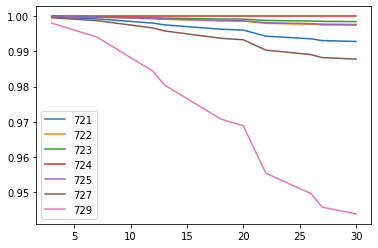

In [98]:
# cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)#_train, conditional_after=data_urti_no_abs_incdt_train.duration_urti_admitted)
survival_func_plot = cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)
plt.plot(survival_func_plot.loc[:, 720:729])
plt.legend(labels=survival_func_plot.loc[:, 720:729].columns, loc ="lower left")

In [383]:
# cph_urti_no_abs_incdt.plot_partial_effects_on_outcome(data_urti_no_abs_incdt.event_urti_admitted, values=[0, 2, 4, 6, 8, 10], cmap='coolwarm')

In [384]:
a = cph_urti_no_abs_incdt.baseline_hazard_
# cph_urti_no_abs_incdt.baseline_survival_
# cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt, data_urti_no_abs_incdt['duration_urti_admitted']<=30)
# cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_no_abs_incdt.txt', a, delimiter=',')

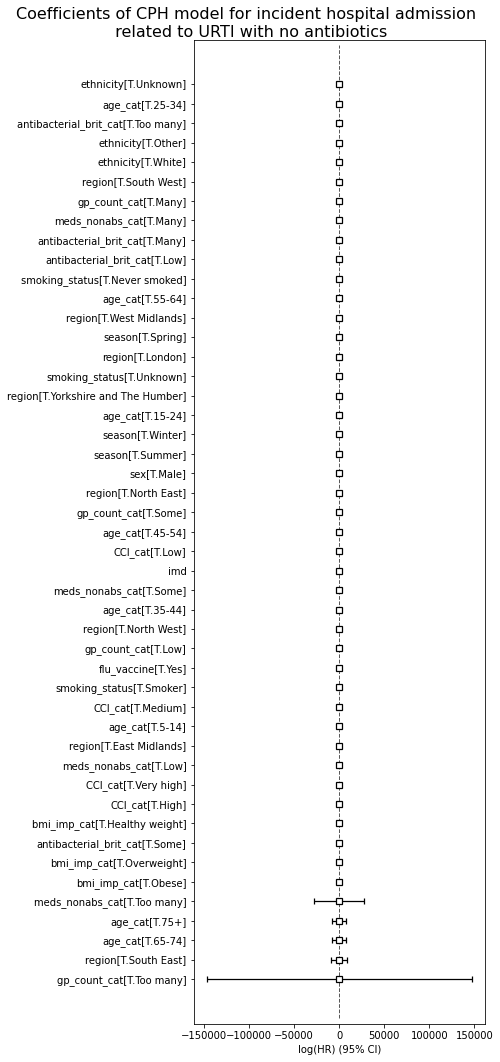

In [412]:
fig, ax = plt.subplots(figsize=(7, 15)
                        )
cph_urti_no_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_cph_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [386]:
# concordance index of cph model with training data
concord_index_urti_no_abs_incdt_train = concordance_index(data_urti_no_abs_incdt_train['duration_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_train), data_urti_no_abs_incdt_train['event_urti_admitted'])
print(f'Concordance index for urti_no_abs_incdt with training data: {concord_index_urti_no_abs_incdt_train}')

# concordance index of cph model with testing data
concord_index_urti_no_abs_incdt_test = concordance_index(data_urti_no_abs_incdt_test['duration_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_test), data_urti_no_abs_incdt_test['event_urti_admitted'])
print(f'Concordance index for urti_no_abs_incdt with testing data: {concord_index_urti_no_abs_incdt_test}')
# print(concordance_index(data_urti_no_abs_incdt_test['event_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_test), data_urti_no_abs_incdt_test['duration_urti_admitted']))

Concordance index for urti_no_abs_incdt with training data: 0.8882310362107686
Concordance index for urti_no_abs_incdt with testing data: 0.5187279670975323


<AxesSubplot:>

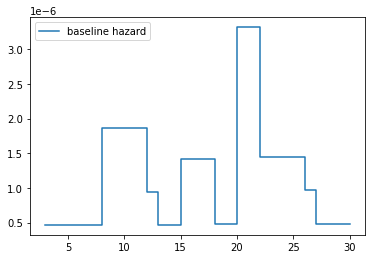

In [172]:
cph_urti_no_abs_incdt.baseline_hazard_.plot(drawstyle="steps")
# baseline hazard: the baseline hazard evaluated at the observed times. Estimated using Breslow’s method.

<AxesSubplot:>

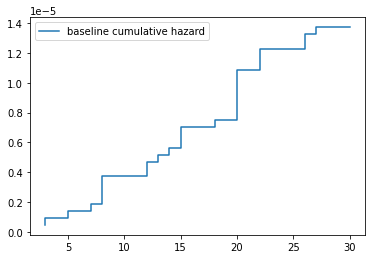

In [179]:
cph_urti_no_abs_incdt.baseline_cumulative_hazard_.plot(drawstyle="steps")
# baseline cumulative hazard: the baseline cumulative hazard evaluated at the observed times. Estimated using Breslow’s method.

<AxesSubplot:>

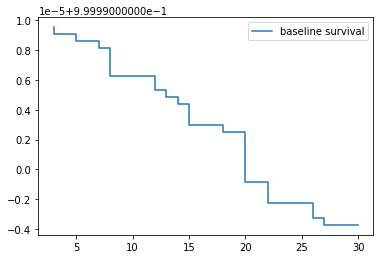

In [161]:
cph_urti_no_abs_incdt.baseline_survival_.plot(drawstyle="steps")
# baseline survival: the baseline survival evaluated at the observed times. Estimated using Breslow’s method

In [162]:
cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt, data_urti_no_abs_incdt['duration_urti_admitted']<=30)

,0,2,4,6,7,9,10,11,14,15,...,7285,7286,7287,7289,7290,7291,7292,7293,7294,7295
1.0,7.610349e-11,0.000133,1.092927e-12,8.165027e-13,0.000221,0.000318,0.000307,0.000158,2.586419e-12,0.000117,...,0.001029,2.115272e-11,2.505132e-12,1.153263e-12,0.000463,0.000344,0.000155,4.497839e-12,1.011256e-12,2.335169e-12
1.0,7.610349e-11,0.000133,1.092927e-12,8.165027e-13,0.000221,0.000318,0.000307,0.000158,2.586419e-12,0.000117,...,0.001029,2.115272e-11,2.505132e-12,1.153263e-12,0.000463,0.000344,0.000155,4.497839e-12,1.011256e-12,2.335169e-12
1.0,7.610349e-11,0.000133,1.092927e-12,8.165027e-13,0.000221,0.000318,0.000307,0.000158,2.586419e-12,0.000117,...,0.001029,2.115272e-11,2.505132e-12,1.153263e-12,0.000463,0.000344,0.000155,4.497839e-12,1.011256e-12,2.335169e-12
1.0,7.610349e-11,0.000133,1.092927e-12,8.165027e-13,0.000221,0.000318,0.000307,0.000158,2.586419e-12,0.000117,...,0.001029,2.115272e-11,2.505132e-12,1.153263e-12,0.000463,0.000344,0.000155,4.497839e-12,1.011256e-12,2.335169e-12
1.0,7.610349e-11,0.000133,1.092927e-12,8.165027e-13,0.000221,0.000318,0.000307,0.000158,2.586419e-12,0.000117,...,0.001029,2.115272e-11,2.505132e-12,1.153263e-12,0.000463,0.000344,0.000155,4.497839e-12,1.011256e-12,2.335169e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.0,7.610349e-11,0.000133,1.092927e-12,8.165027e-13,0.000221,0.000318,0.000307,0.000158,2.586419e-12,0.000117,...,0.001029,2.115272e-11,2.505132e-12,1.153263e-12,0.000463,0.000344,0.000155,4.497839e-12,1.011256e-12,2.335169e-12
1.0,7.610349e-11,0.000133,1.092927e-12,8.165027e-13,0.000221,0.000318,0.000307,0.000158,2.586419e-12,0.000117,...,0.001029,2.115272e-11,2.505132e-12,1.153263e-12,0.000463,0.000344,0.000155,4.497839e-12,1.011256e-12,2.335169e-12
1.0,7.610349e-11,0.000133,1.092927e-12,8.165027e-13,0.000221,0.000318,0.000307,0.000158,2.586419e-12,0.000117,...,0.001029,2.115272e-11,2.505132e-12,1.153263e-12,0.000463,0.000344,0.000155,4.497839e-12,1.011256e-12,2.335169e-12
1.0,7.610349e-11,0.000133,1.092927e-12,8.165027e-13,0.000221,0.000318,0.000307,0.000158,2.586419e-12,0.000117,...,0.001029,2.115272e-11,2.505132e-12,1.153263e-12,0.000463,0.000344,0.000155,4.497839e-12,1.011256e-12,2.335169e-12


In [170]:
cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)

,0,2,4,6,7,9,10,11,14,15,...,7285,7286,7287,7289,7290,7291,7292,7293,7294,7295
3.0,1.0,0.999867,1.0,1.0,0.999779,0.999683,0.999693,0.999842,1.0,0.999883,...,0.998972,1.0,1.0,1.0,0.999537,0.999656,0.999845,1.0,1.0,1.0
5.0,1.0,0.999733,1.0,1.0,0.999557,0.999365,0.999386,0.999684,1.0,0.999765,...,0.997943,1.0,1.0,1.0,0.999074,0.999311,0.999690,1.0,1.0,1.0
7.0,1.0,0.999600,1.0,1.0,0.999336,0.999047,0.999079,0.999526,1.0,0.999648,...,0.996915,1.0,1.0,1.0,0.998611,0.998967,0.999535,1.0,1.0,1.0
8.0,1.0,0.999466,1.0,1.0,0.999114,0.998729,0.998771,0.999367,1.0,0.999530,...,0.995887,1.0,1.0,1.0,0.998148,0.998622,0.999380,1.0,1.0,1.0
12.0,1.0,0.998931,1.0,1.0,0.998226,0.997457,0.997541,0.998733,1.0,0.999059,...,0.991782,1.0,1.0,1.0,0.996295,0.997243,0.998760,1.0,1.0,1.0
13.0,1.0,0.998663,1.0,1.0,0.997782,0.996820,0.996925,0.998416,1.0,0.998823,...,0.989730,1.0,1.0,1.0,0.995368,0.996552,0.998449,1.0,1.0,1.0
14.0,1.0,0.998529,1.0,1.0,0.997559,0.996500,0.996616,0.998256,1.0,0.998704,...,0.988703,1.0,1.0,1.0,0.994903,0.996206,0.998292,1.0,1.0,1.0
15.0,1.0,0.998394,1.0,1.0,0.997335,0.996180,0.996307,0.998097,1.0,0.998586,...,0.987674,1.0,1.0,1.0,0.994437,0.995859,0.998136,1.0,1.0,1.0
18.0,1.0,0.997990,1.0,1.0,0.996665,0.995221,0.995379,0.997618,1.0,0.998230,...,0.984594,1.0,1.0,1.0,0.993041,0.994819,0.997667,1.0,1.0,1.0
20.0,1.0,0.997855,1.0,1.0,0.996441,0.994900,0.995069,0.997458,1.0,0.998111,...,0.983565,1.0,1.0,1.0,0.992574,0.994471,0.997511,1.0,1.0,1.0


In [176]:
# cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt).mean()

cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt).loc[[30]]#.mean()

,0,2,4,6,7,9,10,11,14,15,...,7285,7286,7287,7289,7290,7291,7292,7293,7294,7295
30.0,1.0,0.996084,1.0,1.0,0.993506,0.9907,0.991008,0.995359,1.0,0.996551,...,0.970173,1.0,1.0,1.0,0.986472,0.98992,0.995456,1.0,1.0,1.0


In [139]:
# fig, ax = plt.subplots(figsize=(5, 5)
#                         )
# cph_urti_no_abs_incdt.baseline_survival_.plot(drawstyle="steps", ax=ax)
# # cph_urti_no_abs_incdt.baseline_survival_.plot(ax=ax)
# plt.suptitle('Baseline survival of CPH model for incident hospital\n admission related to URTI with no antibiotics', fontsize=16)
# plt.tight_layout()
# # plt.savefig('../output/hospitalisation_prediction_urti/coef_cph_urti_no_abs_incdt.jpg', bbox_inches='tight')
# plt.show()

In [387]:
# a = [concord_index_urti_no_abs_incdt_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_no_abs_incdt_test.txt', a, delimiter=',')

In [388]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to urti with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_train.jpg', bbox_inches='tight')
# plt.show()

# # t0 (float) – the time to evaluate the probability of event occurring prior at.
# # ICI – mean absolute difference between predicted and observed
# # E50 – median absolute difference between predicted and observed

In [389]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_test, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_test.jpg', bbox_inches='tight')
# plt.show()

In [390]:
cph_urti_no_abs_incdt_train_cumulative_hazard = cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt_train)

cph_urti_no_abs_incdt_train_cumulative_hazard = cph_urti_no_abs_incdt_train_cumulative_hazard.loc[[30]].T

cph_urti_no_abs_incdt_train_cumulative_hazard['event_urti_admitted'] = data_urti_no_abs_incdt_train['event_urti_admitted']

cph_urti_no_abs_incdt_train_cumulative_hazard = cph_urti_no_abs_incdt_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_no_abs_incdt_train_cumulative_hazard

,cumulative_hazard,event_urti_admitted
6524,5.059337e-03,0.0
3004,1.588314e-03,0.0
2152,1.308374e-02,0.0
4566,1.147853e-18,0.0
4987,2.370886e-03,0.0
...,...,...
6519,3.082171e-10,0.0
654,1.012882e-02,0.0
4497,6.305518e-11,0.0
5523,1.980867e-03,0.0


In [391]:
cph_urti_no_abs_incdt_test_cumulative_hazard = cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt_test)

cph_urti_no_abs_incdt_test_cumulative_hazard = cph_urti_no_abs_incdt_test_cumulative_hazard.loc[[30]].T

cph_urti_no_abs_incdt_test_cumulative_hazard['event_urti_admitted'] = data_urti_no_abs_incdt_test['event_urti_admitted']

cph_urti_no_abs_incdt_test_cumulative_hazard = cph_urti_no_abs_incdt_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_no_abs_incdt_test_cumulative_hazard

,cumulative_hazard,event_urti_admitted
5847,3.120323e-02,0.0
211,1.955888e-03,0.0
4450,1.537070e-03,0.0
7074,1.716015e-03,0.0
3732,2.113379e-03,0.0
...,...,...
4263,8.378351e-03,0.0
6841,3.212491e-02,0.0
611,1.161069e-02,0.0
2956,4.644904e-02,0.0


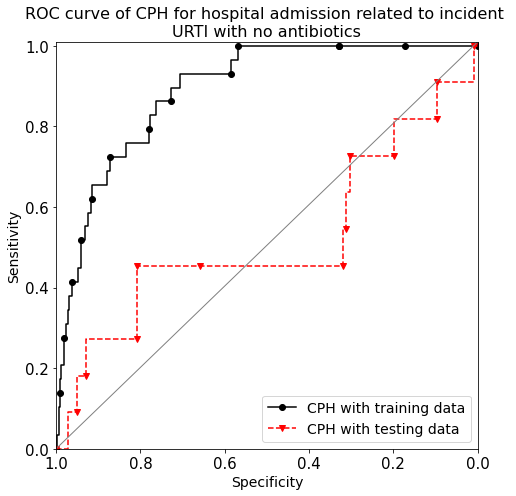

In [392]:
r_fpr1, r_tpr1, _ = roc_curve(cph_urti_no_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_urti_no_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of CPH for hospital admission related to incident \nURTI with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_cph_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [393]:
r_auc1 = roc_auc_score(cph_urti_no_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_urti_no_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_urti_no_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_urti_no_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)

print('AUROC of CPH with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc1))
print('AUROC of CPH with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc2))
print('Brier score of CPH with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier1))
print('Brier score of CPH with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier2))

AUROC of CPH with training data of hospital admission related to incident URTI with no antibiotics = 0.8898
AUROC of CPH with testing data of hospital admission related to incident URTI with no antibiotics = 0.5191
Brier score of CPH with training data of hospital admission related to incident URTI with no antibiotics = 0.0076
Brier score of CPH with testing data of hospital admission related to incident URTI with no antibiotics = 0.0094


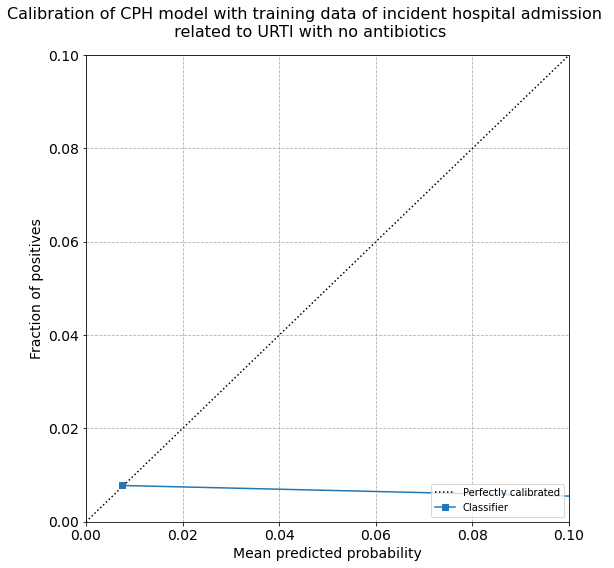

In [398]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_no_abs_incdt_train = CalibrationDisplay.from_predictions(cph_urti_no_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard, ax = axe)
plt.suptitle('Calibration of CPH model with training data of incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_no_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

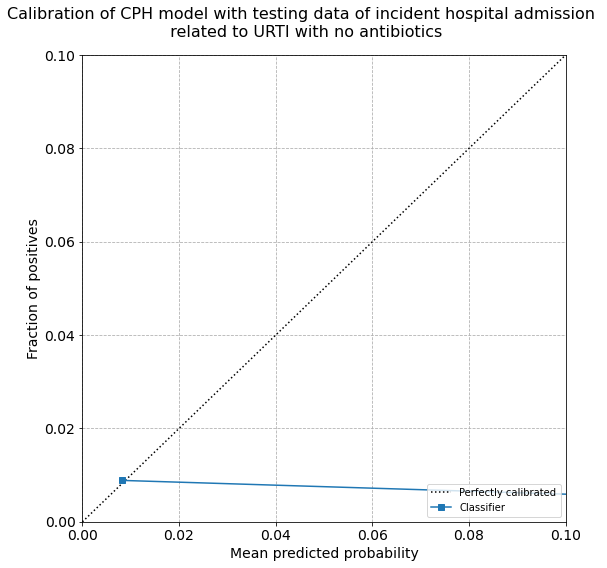

In [399]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_no_abs_incdt_test = CalibrationDisplay.from_predictions(cph_urti_no_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard, ax = axe)
plt.suptitle('Calibration of CPH model with testing data of incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_no_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [400]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/cph_urti_no_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['Concordance index for urti_no_abs_incdt with testing data: %.4f' % (concord_index_urti_no_abs_incdt_test), 
              '\nConcordance index for urti_no_abs_incdt with training data: %.4f' % (concord_index_urti_no_abs_incdt_train),
              '\nAUROC of CPH with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier2)])

In [394]:
cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt).loc[[30]]

,0,2,4,6,7,9,10,11,14,15,...,7285,7286,7287,7289,7290,7291,7292,7293,7294,7295
30.0,1.0,0.992787,1.0,1.0,0.990014,1.0,0.992906,0.994758,1.0,0.996537,...,0.960525,1.0,1.0,1.0,0.991487,0.981489,0.993229,1.0,1.0,1.0


In [395]:
1 - cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt).loc[[30]]

,0,2,4,6,7,9,10,11,14,15,...,7285,7286,7287,7289,7290,7291,7292,7293,7294,7295
30.0,1.0,0.992761,1.0,1.0,0.989964,1.0,0.992881,0.994744,1.0,0.996531,...,0.959725,1.0,1.0,1.0,0.991451,0.981315,0.993206,1.0,1.0,1.0


In [396]:
cph_urti_no_abs_incdt.baseline_cumulative_hazard_.loc[[30]]

,baseline cumulative hazard
30.0,0.000005


In [488]:
coef_cph = pd.DataFrame(cph_urti_no_abs_incdt.hazard_ratios_)
coef_cph = coef_cph.reset_index()
coef_cph

,covariate,exp(coef)
0,CCI_cat[T.Low],9.877091e-01
1,CCI_cat[T.Medium],6.376556e-01
2,CCI_cat[T.High],4.042859e-01
3,CCI_cat[T.Very high],5.463924e-01
4,age_cat[T.15-24],1.310612e+00
5,age_cat[T.25-34],3.501820e+00
6,age_cat[T.35-44],8.758581e-01
7,age_cat[T.45-54],1.007058e+00
8,age_cat[T.5-14],6.443418e-01
9,age_cat[T.55-64],1.483015e+00


#### 4-1-2- Incident hospital admission related to URTI with antibiotics

In [401]:
data_urti_abs_incdt.columns

Index(['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine',
       'bmi_imp_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season',
       'antibacterial_brit_cat', 'meds_nonabs_cat', 'event_urti_admitted',
       'duration_urti_admitted', 'gp_cons_urti_ab', 'incdt_urti_date'],
      dtype='object')

In [402]:
data_urti_abs_incdt.shape

(523, 17)

In [403]:
#keep relevant variables
data_urti_abs_incdt = data_urti_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 
                                           'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 
                                           'meds_nonabs_cat', 'hx_hosp_cat', 'event_urti_admitted', 'duration_urti_admitted']]

In [404]:
# printing number of missing values in each variable 
data_urti_abs_incdt.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
gp_count_cat              0
flu_vaccine               0
bmi_imp_cat               0
region                    0
imd                       0
ethnicity                 0
smoking_status            0
season                    0
antibacterial_brit_cat    0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [406]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_abs_incdt_train, data_urti_abs_incdt_test = train_test_split(data_urti_abs_incdt, test_size=0.25, random_state=42)

print(f'shape of data_urti_abs_incdt for training: {data_urti_abs_incdt_train.shape}')
print(f'shape of data_urti_abs_incdt for testing: {data_urti_abs_incdt_test.shape}')

shape of data_urti_abs_incdt for training: (392, 15)
shape of data_urti_abs_incdt for testing: (131, 15)


In [407]:
cph_urti_abs_incdt = CoxPHFitter().fit(data_urti_abs_incdt_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + gp_count_cat + flu_vaccine + bmi_cat + region + imd + ethnicity + smoking_status + season + antibacterial_brit_cat + meds_nonabs_cat + hx_hosp_cat"
        )
cph_urti_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 392 total observations, 386 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 392
number of events observed = 6
   partial log-likelihood = -0.69
         time fit was run = 2022-05-19 18:40:34 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
CCI_cat[T.Low]                      15.55   5.68e+06  103701.56       -203235.77        203266.87                 0.00                  inf
CCI_cat[T.Medium]                  -10.05       0.00   85519.77       -167625.73        167605.62                 0.00                  inf
CCI_cat[T.High]                     -5.20       0.01   76378.55       -149704.40        149694.01                 0.00                  inf
CCI_cat[T.Very high]                -0.26       0.77  112608.73       -220709.31        220708.80                 0.00                  inf
age_cat[T.15-24]                     3.88      48.47  101380.69       -198698.62        198706.38                 0.00                  inf
age_cat[T.25-34]                    36.94   1.11e+16   39842.11        -78052.16         78126.05                 0.00                  inf
age_cat[T.35-44]                    -9.00       0.00   84910.90       -166431.30        166413.30                 0.00                  inf
age_cat[T.45-54]                   -69.59       0.00   85304.03       -167262.41        167123.23                 0.00                  inf
age_cat[T.5-14]                    -26.64       0.00   79570.93       -155982.79        155929.51                 0.00                  inf
age_cat[T.55-64]                   -21.09       0.00  115390.87       -226183.03        226140.85                 0.00                  inf
age_cat[T.65-74]                   -26.32       0.00  257384.22       -504490.13        504437.48                 0.00                  inf
age_cat[T.75+]                     -10.15       0.00  105104.79       -206011.76        205991.46                 0.00                  inf
antibacterial_brit_cat[T.Low]      -54.11       0.00   69725.45       -136713.48        136605.25                 0.00                  inf
antibacterial_brit_cat[T.Some]      -5.23       0.01   46323.94        -90798.48         90788.01                 0.00                  inf
antibacterial_brit_cat[T.Many]     -51.97       0.00  145580.95       -285385.38        285281.45                 0.00                  inf
antibacterial_brit_cat[T.Too many] -17.17       0.00  172551.74       -338212.36        338178.02                 0.00                  inf
bmi_imp_cat[T.Healthy weight]       91.00   3.32e+39   83467.34       -163501.98        163683.99                 0.00                  inf
bmi_imp_cat[T.Overweight]           51.06   1.50e+22  121492.14       -238069.15        238171.28                 0.00                  inf
bmi_imp_cat[T.Obese]                -1.89       0.15   94280.53       -184788.33        184784.55                 0.00                  inf
ethnicity[T.Other]                 -37.12       0.00   68856.37       -134993.13        134918.89                 0.00                  inf
ethnicity[T.Unknown]               -30.57       0.00   44954.56        -88139.90         88078.75                 0.00                  inf
ethnicity[T.White]                 -61.11       0.00   68955.86       -135212.12        135089.89                 0.00                  inf
flu_vaccine[T.Yes]                   5.94     380.32   83440.56       -163534.55        163546.43                 0.00                  inf
gp_count_cat[T.Low]                 14.73   2.50e+06   40760.23        -79873.86         79903.32                 0

In [408]:
output = GetPrintSummary(cph_urti_abs_incdt)

with open('../output/hospitalisation_prediction_urti/cph_urti_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

16050


In [409]:
a = cph_urti_abs_incdt.baseline_hazard_
# cph_urti_abs_incdt.baseline_survival_
# cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt, data_urti_abs_incdt['duration_urti_admitted']<=30)
# cph_urti_abs_incdt.predict_survival_function(data_urti_abs_incdt)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_abs_incdt.txt', a, delimiter=',')

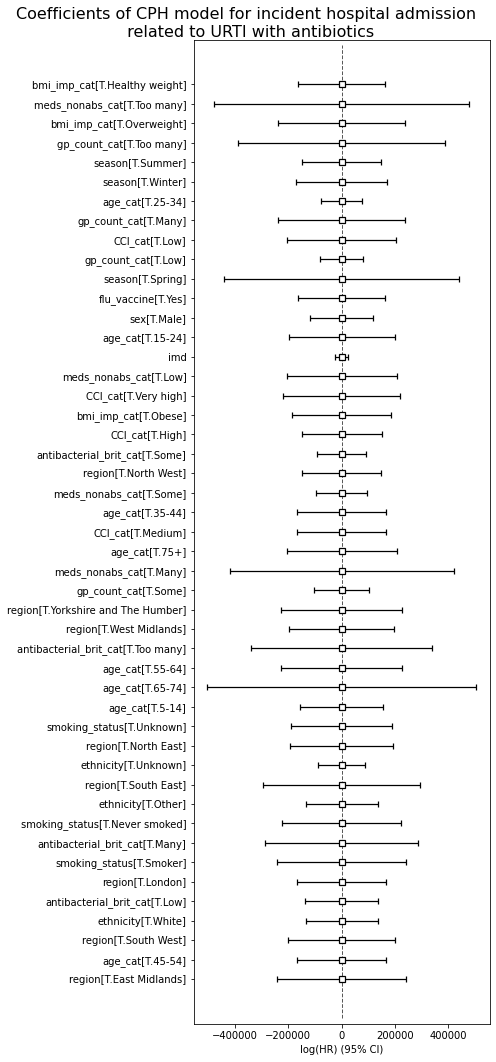

In [413]:
fig, ax = plt.subplots(figsize=(7, 15)
                        )
cph_urti_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_cph_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [414]:
# concordance index of cph model with training data
concord_index_urti_abs_incdt_train = concordance_index(data_urti_abs_incdt_train['duration_urti_admitted'], -cph_urti_abs_incdt.predict_partial_hazard(data_urti_abs_incdt_train), data_urti_abs_incdt_train['event_urti_admitted'])
print(f'Concordance index for urti_abs_incdt with training data: {concord_index_urti_abs_incdt_train}')

# concordance index of cph model with testing data
concord_index_urti_abs_incdt_test = concordance_index(data_urti_abs_incdt_test['duration_urti_admitted'], -cph_urti_abs_incdt.predict_partial_hazard(data_urti_abs_incdt_test), data_urti_abs_incdt_test['event_urti_admitted'])
print(f'Concordance index for urti_abs_incdt with testing data: {concord_index_urti_abs_incdt_test}')

Concordance index for urti_abs_incdt with training data: 1.0
Concordance index for urti_abs_incdt with testing data: 0.37065637065637064


In [143]:
# a = [concord_index_urti_abs_incdt_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_abs_incdt_test.txt', a, delimiter=',')

In [144]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_train, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to URTI with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_train.jpg', bbox_inches='tight')
# plt.show()

In [145]:
# survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt, t0=30)

In [146]:
# survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_train, t0=30)

In [147]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_test, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to urti with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_test.jpg', bbox_inches='tight')
# plt.show()

In [415]:
cph_urti_abs_incdt_train_cumulative_hazard = cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt_train)

cph_urti_abs_incdt_train_cumulative_hazard = cph_urti_abs_incdt_train_cumulative_hazard.loc[[30]].T

cph_urti_abs_incdt_train_cumulative_hazard['event_urti_admitted'] = data_urti_abs_incdt_train['event_urti_admitted']

cph_urti_abs_incdt_train_cumulative_hazard = cph_urti_abs_incdt_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_abs_incdt_train_cumulative_hazard

,cumulative_hazard,event_urti_admitted
238,2.303899e-58,0.0
4855,3.170519e-84,0.0
857,4.896160e-31,0.0
5057,2.691161e-44,0.0
4949,2.760694e-58,0.0
...,...,...
1078,2.420672e-11,0.0
1586,1.740721e-55,0.0
3763,7.778710e-10,0.0
5938,3.282876e-56,0.0


In [416]:
cph_urti_abs_incdt_test_cumulative_hazard = cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt_test)

cph_urti_abs_incdt_test_cumulative_hazard = cph_urti_abs_incdt_test_cumulative_hazard.loc[[30]].T

cph_urti_abs_incdt_test_cumulative_hazard['event_urti_admitted'] = data_urti_abs_incdt_test['event_urti_admitted']

cph_urti_abs_incdt_test_cumulative_hazard = cph_urti_abs_incdt_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_abs_incdt_test_cumulative_hazard

,cumulative_hazard,event_urti_admitted
7210,3.029335e-32,0.0
5294,3.546022e-50,0.0
105,2.516353e-28,0.0
2586,1.213393e-15,0.0
1197,6.136255e-60,0.0
...,...,...
4956,7.014151e-49,0.0
1262,5.282242e-19,0.0
6260,1.193807e-39,0.0
2774,3.881340e-56,0.0


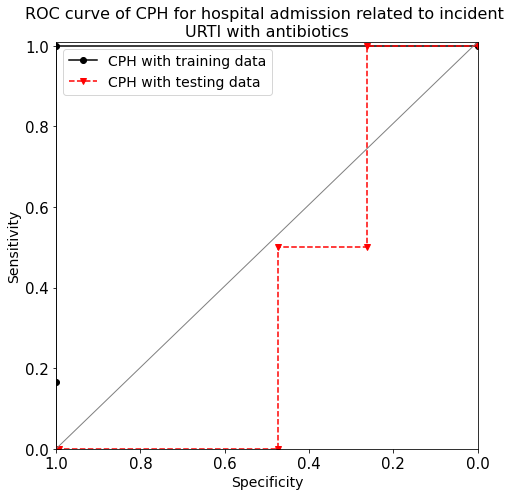

In [417]:
r_fpr1, r_tpr1, _ = roc_curve(cph_urti_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_urti_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of CPH for hospital admission related to incident \nURTI with antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_cph_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [418]:
cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard.max()

6.824949744368739e+20

In [419]:
# cph_urti_abs_incdt_train_cumulative_hazard.describe()
cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard.max()

5.806123413222461e+30

In [420]:
cph_urti_abs_incdt_train_cumulative_hazard.shape

(392, 2)

In [421]:
cph_urti_abs_incdt_train_cumulative_hazard = cph_urti_abs_incdt_train_cumulative_hazard[cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard <= 1]
cph_urti_abs_incdt_train_cumulative_hazard.max()

cumulative_hazard      7.125602e-09
event_urti_admitted    0.000000e+00
dtype: float64

In [422]:
cph_urti_abs_incdt_train_cumulative_hazard.shape

(386, 2)

In [424]:
r_auc1 = roc_auc_score(cph_urti_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_urti_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_urti_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_urti_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard)

print('AUROC of CPH with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc1))
print('AUROC of CPH with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc2))
print('Brier score of CPH with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier1))
print('Brier score of CPH with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier2))

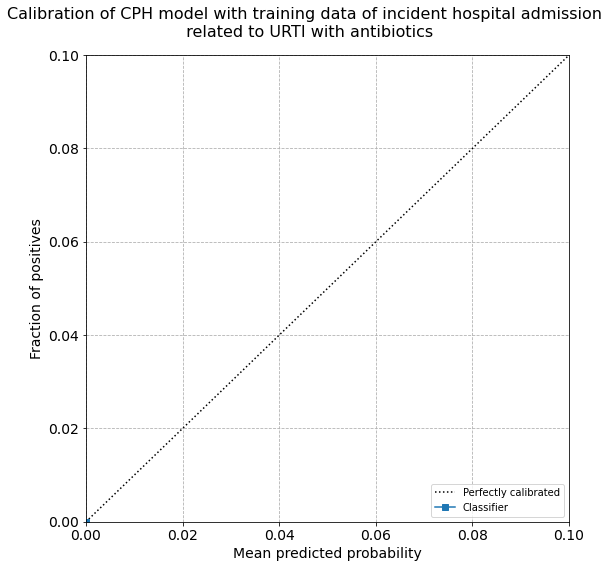

In [428]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_abs_incdt_train = CalibrationDisplay.from_predictions(cph_urti_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard, ax = axe)
plt.suptitle('Calibration of CPH model with training data of incident hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

In [430]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_abs_incdt_train = CalibrationDisplay.from_predictions(cph_urti_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard, ax = axe)
plt.suptitle('Calibration of CPH model with testing data of incident hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [431]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/cph_urti_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['Concordance index for urti_abs_incdt with testing data: %.4f' % (concord_index_urti_abs_incdt_test), 
              '\nConcordance index for urti_abs_incdt with training data: %.4f' % (concord_index_urti_abs_incdt_train),
              '\nAUROC of CPH with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier2)])

#### 4-1-3- Prevalent hospital admission related to URTI with no antibiotics

In [432]:
#keep relevant variables
data_urti_no_abs_prevl = data_urti_no_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat_imp', 'region', 
                                                 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 
                                                 'meds_nonabs_cat', 'hx_hosp_cat', 'event_urti_admitted', 'duration_urti_admitted']]

In [433]:
# printing number of missing values in each variable 
data_urti_no_abs_prevl.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
gp_count_cat              0
flu_vaccine               0
bmi_imp_cat               0
region                    0
imd                       0
ethnicity                 0
smoking_status            0
season                    0
antibacterial_brit_cat    0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [434]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test = train_test_split(data_urti_no_abs_prevl, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_prevl for training: {data_urti_no_abs_prevl_train.shape}')
print(f'shape of data_urti_no_abs_prevl for testing: {data_urti_no_abs_prevl_test.shape}')

shape of data_urti_no_abs_prevl for training: (405, 15)
shape of data_urti_no_abs_prevl for testing: (135, 15)


In [435]:
cph_urti_no_abs_prevl = CoxPHFitter().fit(data_urti_no_abs_prevl_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + gp_count_cat + flu_vaccine + bmi_cat + region + imd + ethnicity + smoking_status + season + antibacterial_brit_cat + meds_nonabs_cat + hx_hosp_cat"
        )
cph_urti_no_abs_prevl.print_summary()

<lifelines.CoxPHFitter: fitted with 405 total observations, 403 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 405
number of events observed = 2
   partial log-likelihood = -0.00
         time fit was run = 2022-05-19 18:44:11 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
CCI_cat[T.Low]                       2.68      14.65   25875.84        -50713.03         50718.40                 0.00                  inf
CCI_cat[T.Medium]                    0.51       1.66   37038.19        -72593.01         72594.02                 0.00                  inf
CCI_cat[T.High]                      7.66    2123.44   33054.84        -64778.63         64793.95                 0.00                  inf
CCI_cat[T.Very high]                 5.63     279.46   15095.74        -29581.48         29592.75                 0.00                  inf
age_cat[T.15-24]                     3.77      43.51   42496.04        -83286.93         83294.47                 0.00                  inf
age_cat[T.25-34]                   -12.64       0.00   47018.58        -92167.38         92142.09                 0.00                  inf
age_cat[T.35-44]                     5.87     354.22   36316.10        -71172.38         71184.12                 0.00                  inf
age_cat[T.45-54]                    -1.90       0.15   48182.70        -94438.26         94434.46                 0.00                  inf
age_cat[T.5-14]                      0.72       2.06   45663.82        -89498.72         89500.16                 0.00                  inf
age_cat[T.55-64]                    -2.12       0.12   46911.71        -91947.38         91943.14                 0.00                  inf
age_cat[T.65-74]                    -0.35       0.70   40248.94        -78886.82         78886.12                 0.00                  inf
age_cat[T.75+]                      -2.85       0.06   40483.67        -79349.38         79343.68                 0.00                  inf
antibacterial_brit_cat[T.Low]       -3.15       0.04   24686.90        -48388.59         48382.28                 0.00                  inf
antibacterial_brit_cat[T.Some]      -1.08       0.34   28991.39        -56823.15         56821.00                 0.00                  inf
antibacterial_brit_cat[T.Many]       0.13       1.13   31699.01        -62128.79         62129.04                 0.00                  inf
antibacterial_brit_cat[T.Too many]  -3.18       0.04  115060.80       -225518.20        225511.84                 0.00                  inf
bmi_imp_cat[T.Healthy weight]       -8.99       0.00   38983.04        -76414.34         76396.37                 0.00                  inf
bmi_imp_cat[T.Overweight]          -20.00       0.00   34824.86        -68275.46         68235.47                 0.00                  inf
bmi_imp_cat[T.Obese]               -14.99       0.00   21817.68        -42776.86         42746.87                 0.00                  inf
ethnicity[T.Other]                   6.21     500.13   22274.33        -43650.68         43663.11                 0.00                  inf
ethnicity[T.Unknown]                -6.22       0.00   23356.10        -45783.33         45770.89                 0.00                  inf
ethnicity[T.White]                  -6.27       0.00   20184.06        -39566.30         39553.76                 0.00                  inf
flu_vaccine[T.Yes]                   1.98       7.25   30533.87        -59843.31         59847.27                 0.00                  inf
gp_count_cat[T.Low]                 -5.11       0.01   31872.73        -62474.51         62464.28                 0

In [436]:
output = GetPrintSummary(cph_urti_no_abs_prevl)

with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_prevl_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

15897


In [437]:
a = cph_urti_no_abs_prevl.baseline_hazard_
# cph_urti_no_abs_prevl.baseline_survival_
# cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl, data_urti_no_abs_prevl['duration_urti_admitted']<=30)
# cph_urti_no_abs_prevl.predict_survival_function(data_urti_no_abs_prevl)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_no_abs_prevl.txt', a, delimiter=',')

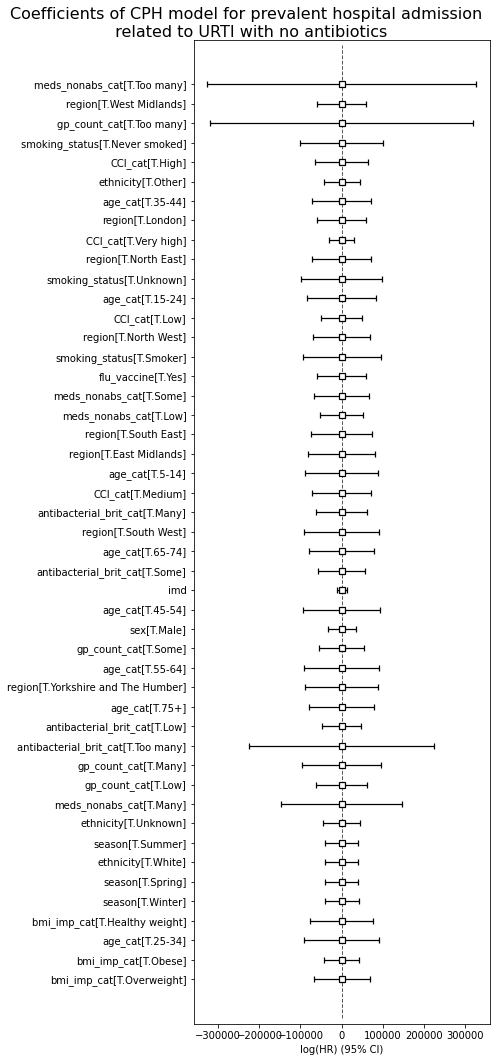

In [439]:
fig, ax = plt.subplots(figsize=(7, 15)
                        )
cph_urti_no_abs_prevl.plot()
plt.suptitle('Coefficients of CPH model for prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_cph_urti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# data_urti_no_abs_prevl_test.columns

In [442]:
# concordance index of cph model with training data
concord_index_urti_no_abs_prevl_train = concordance_index(data_urti_no_abs_prevl_train['duration_urti_admitted'], -cph_urti_no_abs_prevl.predict_partial_hazard(data_urti_no_abs_prevl_train), data_urti_no_abs_prevl_train['event_urti_admitted'])
print(f'Concordance index for cph_urti_no_abs_prevl with training data: {concord_index_urti_no_abs_prevl_train}')

# concordance index of cph model with testing data
concord_index_urti_no_abs_prevl_test = concordance_index(data_urti_no_abs_prevl_test['duration_urti_admitted'], -cph_urti_no_abs_prevl.predict_partial_hazard(data_urti_no_abs_prevl_test), data_urti_no_abs_prevl_test['event_urti_admitted'])
print(f'Concordance index for cph_urti_no_abs_prevl with testing data: {concord_index_urti_no_abs_prevl_test}')

In [441]:
# a = [concord_index_urti_no_abs_prevl_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_no_abs_prevl_test.txt', a, delimiter=',')

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_train, t0=30)
# # plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_train.jpg', bbox_inches='tight')
# plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_test, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_test.jpg', bbox_inches='tight')
# plt.show()

In [443]:
cph_urti_no_abs_prevl_train_cumulative_hazard = cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl_train)

cph_urti_no_abs_prevl_train_cumulative_hazard = cph_urti_no_abs_prevl_train_cumulative_hazard.loc[[30]].T

cph_urti_no_abs_prevl_train_cumulative_hazard['event_urti_admitted'] = data_urti_no_abs_prevl_train['event_urti_admitted']

cph_urti_no_abs_prevl_train_cumulative_hazard = cph_urti_no_abs_prevl_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_no_abs_prevl_train_cumulative_hazard

,cumulative_hazard,event_urti_admitted
5230,8.915153e-14,0.0
6814,1.043153e-15,0.0
6404,6.152071e-13,0.0
3015,3.500932e-19,0.0
4040,2.042923e-13,0.0
...,...,...
1120,2.314488e-10,0.0
1678,2.660248e-11,0.0
3709,5.118561e-13,0.0
5805,8.198187e-13,0.0


In [444]:
cph_urti_no_abs_prevl_test_cumulative_hazard = cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl_test)

cph_urti_no_abs_prevl_test_cumulative_hazard = cph_urti_no_abs_prevl_test_cumulative_hazard.loc[[30]].T

cph_urti_no_abs_prevl_test_cumulative_hazard['event_urti_admitted'] = data_urti_no_abs_prevl_test['event_urti_admitted']

cph_urti_no_abs_prevl_test_cumulative_hazard = cph_urti_no_abs_prevl_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_no_abs_prevl_test_cumulative_hazard

,cumulative_hazard,event_urti_admitted
3199,1.332826e-14,0.0
1148,1.846460e-15,0.0
6927,1.010035e-02,0.0
1472,7.679531e-16,0.0
6285,9.726546e-20,0.0
...,...,...
1852,1.830415e-14,0.0
5055,1.215099e-18,0.0
2968,3.206120e-20,0.0
2467,1.639591e-10,0.0


In [445]:
# cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl_test)[[1103, 188, 6651]]

In [447]:
r_fpr1, r_tpr1, _ = roc_curve(cph_urti_no_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_urti_no_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of CPH for hospital admission related to prevalent \nURTI with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_cph_urti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [169]:
cph_urti_no_abs_prevl_train_cumulative_hazard.shape

(429, 2)

In [170]:
cph_urti_no_abs_prevl_train_cumulative_hazard.max()

cumulative_hazard      7.106619
event_urti_admitted    1.000000
dtype: float64

In [171]:
cph_urti_no_abs_prevl_train_cumulative_hazard = cph_urti_no_abs_prevl_train_cumulative_hazard[cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard <= 1]
cph_urti_no_abs_prevl_train_cumulative_hazard.max()

cumulative_hazard      0.669541
event_urti_admitted    1.000000
dtype: float64

In [172]:
cph_urti_no_abs_prevl_train_cumulative_hazard.shape

(426, 2)

In [318]:
r_auc1 = roc_auc_score(cph_urti_no_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_urti_no_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_urti_no_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_urti_no_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)

print('AUROC of CPH with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc1))
print('AUROC of CPH with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc2))
print('Brier score of CPH with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier1))
print('Brier score of CPH with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier2))

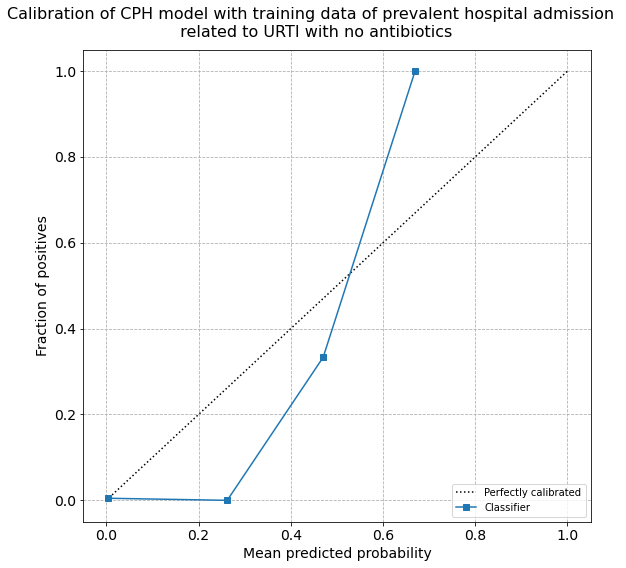

In [173]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_no_abs_incdt_train = CalibrationDisplay.from_predictions(cph_urti_no_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard, ax = axe)
plt.suptitle('Calibration of CPH model with training data of prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_no_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [174]:
cph_urti_no_abs_prevl_test_cumulative_hazard.shape

(143, 2)

In [175]:
cph_urti_no_abs_prevl_test_cumulative_hazard.max()

cumulative_hazard      1681.396122
event_urti_admitted       0.000000
dtype: float64

In [341]:
# a = cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl_train)
# a.loc[[188]]

In [176]:
cph_urti_no_abs_prevl_test_cumulative_hazard = cph_urti_no_abs_prevl_test_cumulative_hazard[cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard <= 1]
cph_urti_no_abs_prevl_test_cumulative_hazard.max()

cumulative_hazard      0.61289
event_urti_admitted    0.00000
dtype: float64

In [177]:
cph_urti_no_abs_prevl_test_cumulative_hazard.shape

(139, 2)

In [350]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_no_abs_incdt_test = CalibrationDisplay.from_predictions(cph_urti_no_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard, ax = axe)
plt.suptitle('Calibration of CPH model with testing data of prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_no_abs_prevl_test.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/cph_urti_no_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['Concordance index for urti_no_abs_prevl with testing data: %.4f' % (concord_index_urti_no_abs_prevl_test), 
              '\nConcordance index for urti_no_abs_prevl with training data: %.4f' % (concord_index_urti_no_abs_prevl_train),
              '\nAUROC of CPH with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier2)])

#### 4-1-4- Prevalent hospital admission related to URTI with antibiotics

In [360]:
# data_urti_abs_prevl.columns

In [361]:
# #keep relevant variables
# data_urti_abs_prevl = data_urti_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat', 
#                                            'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp', 'season', 
#                                            'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
#                                            'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
#                                            'event_urti_admitted', 'duration_urti_admitted']]

In [362]:
# # print number of missing values in each variable 
# data_urti_abs_prevl.isnull().sum()

In [363]:
# #randomly splitting data into training (%75) and testing (%25)
# data_urti_abs_prevl_train, data_urti_abs_prevl_test = train_test_split(data_urti_abs_prevl, test_size=0.2)

# print(f'shape of data_urti_abs_prevl for training: {data_urti_abs_prevl_train.shape}')
# print(f'shape of data_urti_abs_prevl for testing: {data_urti_abs_prevl_test.shape}')

In [364]:
# cph_urti_abs_prevl = CoxPHFitter().fit(data_urti_abs_prevl_train,
#         duration_col='duration_urti_admitted',
#         event_col='event_urti_admitted',
#         formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine + bmi_imp_cat + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season"# + antibacterial_brit_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # season +
#         )
# cph_urti_abs_prevl.print_summary()

In [365]:
# output = GetPrintSummary(cph_urti_abs_prevl)

# with open('../output/hospitalisation_prediction_urti/cph_urti_abs_prevl_summary.html', "w") as fo:
#     print(fo.write(output))
#     fo.close()

In [366]:
# a = cph_urti_abs_prevl.baseline_hazard_

# # save 
# np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_abs_prevl.txt', a, delimiter=',')

In [367]:
# fig, ax = plt.subplots(figsize=(5, 9)
#                         )
# cph_urti_no_abs_prevl.plot()
# plt.suptitle('Coefficients of CPH model for prevalent hospital admission \n related to URTI with antibiotics', fontsize=16)
# #_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
# #                        rotation=45, fontsize=12, ha='right')
# plt.savefig('../output/hospitalisation_prediction_urti/coef_cph_urti_abs_prevl.jpg', bbox_inches='tight')
# plt.show()

In [368]:
# # concordance index of cph model with testing data
# concord_index_urti_abs_prevl_test = concordance_index(data_urti_abs_prevl_test['duration_urti_admitted'], -cph_urti_abs_prevl.predict_partial_hazard(data_urti_abs_prevl_test), data_urti_abs_prevl_test['event_urti_admitted'])
# print(f'Concordance index for cph_urti_abs_prevl with testing data: {concord_index_urti_abs_prevl_test}')

In [369]:
# a = [concord_index_urti_abs_prevl_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_abs_prevl_test.txt', a, delimiter=',')

In [370]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_abs_prevl_train, t0=30)
# # plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_prevl_train.jpg', bbox_inches='tight')
# plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_abs_prevl_test, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_prevl_test.jpg', bbox_inches='tight')
# plt.show()

## 5- Logistic regression
### 5-1- URTI
#### 5-1-1- Incident hospital admission related to URTI with no antibiotics

In [448]:
data_urti_no_abs_incdt.head()

,age_cat,sex,CCI_cat,gp_count_cat,flu_vaccine,bmi_imp_cat,region,imd,ethnicity,smoking_status,season,antibacterial_brit_cat,meds_nonabs_cat,event_urti_admitted,duration_urti_admitted
0,75+,Female,Very low,Many,No,Healthy weight,East,1,Unknown,Never smoked,Spring,Very low,Some,0.0,30.0
2,35-44,Male,Very low,Very low,No,Obese,North West,3,White,Unknown,Winter,Very low,Very low,0.0,30.0
4,75+,Female,Low,Some,No,Overweight,North East,5,White,Smoker,Spring,Some,Very low,0.0,30.0
6,75+,Male,Very high,Some,No,Obese,North East,3,White,Smoker,Winter,Very low,Very low,0.0,30.0
7,25-34,Female,Very low,Very low,No,Obese,Yorkshire and The Humber,3,White,Unknown,Summer,Some,Very low,0.0,30.0


In [197]:
data_urti_no_abs_incdt.shape

(4913, 20)

In [450]:
# encoding categorical data for LR

# data = data_urti_abs_incdt[['event_urti_admitted', 'duration_urti_admitted', 'age', 'sex', 'CCI_cat', 'bmi_imp', 'bmi_imp_cat', 'gp_count_imp', 'gp_count_imp_cat', 'region_imp', 'season', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat', 'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat']].reset_index()
data = data_urti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_imp_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
# passing bridge-types-cat column (label encoded values of bridge_types)
data_urti_no_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_imp_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat']]).toarray())
data_urti_no_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_imp_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat']].columns)
# data_urti_abs_incdt_enc = data.join(data_urti_abs_incdt_enc)
# data_urti_abs_incdt_enc = data_urti_abs_incdt_enc.drop(columns=['index', ])

data_urti_no_abs_incdt_enc.head()

,age_cat_0-4,age_cat_15-24,age_cat_25-34,age_cat_35-44,age_cat_45-54,age_cat_5-14,age_cat_55-64,age_cat_65-74,age_cat_75+,sex_Female,...,antibacterial_brit_cat_Low,antibacterial_brit_cat_Many,antibacterial_brit_cat_Some,antibacterial_brit_cat_Too many,antibacterial_brit_cat_Very low,meds_nonabs_cat_Low,meds_nonabs_cat_Many,meds_nonabs_cat_Some,meds_nonabs_cat_Too many,meds_nonabs_cat_Very low
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [451]:
data_urti_no_abs_incdt_enc.shape

(4976, 64)

In [452]:
data_urti_no_abs_incdt_enc.columns

Index(['age_cat_0-4', 'age_cat_15-24', 'age_cat_25-34', 'age_cat_35-44',
       'age_cat_45-54', 'age_cat_5-14', 'age_cat_55-64', 'age_cat_65-74',
       'age_cat_75+', 'sex_Female', 'sex_Male', 'CCI_cat_High', 'CCI_cat_Low',
       'CCI_cat_Medium', 'CCI_cat_Very high', 'CCI_cat_Very low',
       'gp_count_cat_Low', 'gp_count_cat_Many', 'gp_count_cat_Some',
       'gp_count_cat_Too many', 'gp_count_cat_Very low', 'flu_vaccine_No',
       'flu_vaccine_Yes', 'bmi_imp_cat_Healthy weight', 'bmi_imp_cat_Obese',
       'bmi_imp_cat_Overweight', 'bmi_imp_cat_Underweight', 'region_East',
       'region_East Midlands', 'region_London', 'region_North East',
       'region_North West', 'region_South East', 'region_South West',
       'region_West Midlands', 'region_Yorkshire and The Humber', 'imd_0',
       'imd_1', 'imd_2', 'imd_3', 'imd_4', 'imd_5', 'ethnicity_Asian',
       'ethnicity_Other', 'ethnicity_Unknown', 'ethnicity_White',
       'smoking_status_Ex-smoker', 'smoking_status_Never smok

In [453]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_incdt_lr_X_train, data_urti_no_abs_incdt_lr_X_test, data_urti_no_abs_incdt_lr_y_train, data_urti_no_abs_incdt_lr_y_test = train_test_split(data_urti_no_abs_incdt_enc, data_urti_no_abs_incdt.event_urti_admitted, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_incdt_lr_X for training: {data_urti_no_abs_incdt_lr_X_train.shape}')
print(f'shape of data_urti_no_abs_incdt_lr_X for testing: {data_urti_no_abs_incdt_lr_X_test.shape}')
print(f'shape of data_urti_no_abs_incdt_lr_y for training: {data_urti_no_abs_incdt_lr_y_train.shape}')
print(f'shape of data_urti_no_abs_incdt_lr_y for testing: {data_urti_no_abs_incdt_lr_y_test.shape}')

shape of data_urti_no_abs_incdt_lr_X for training: (3732, 64)
shape of data_urti_no_abs_incdt_lr_X for testing: (1244, 64)
shape of data_urti_no_abs_incdt_lr_y for training: (3732,)
shape of data_urti_no_abs_incdt_lr_y for testing: (1244,)


In [454]:
#build LR model
lr_urti_no_abs_incdt = LogisticRegression().fit(data_urti_no_abs_incdt_lr_X_train, data_urti_no_abs_incdt_lr_y_train)

#prediction of hsopital admission related to urti of training data using lr
pred_proba_urti_no_abs_incdt_train = lr_urti_no_abs_incdt.predict_proba(data_urti_no_abs_incdt_lr_X_train)
# pred_proba_urti_no_abs_incdt_train

#calculate score of lr_urti_no_abs_incdt with training data
lr_urti_no_abs_incdt_training_score = lr_urti_no_abs_incdt.score(data_urti_no_abs_incdt_lr_X_train, data_urti_no_abs_incdt_lr_y_train)
print(f'score of lr_urti_no_abs_incdt with training data: {lr_urti_no_abs_incdt_training_score}')

#prediction of hsopital admission related to urti of testing data using lr
pred_proba_urti_no_abs_incdt_test = lr_urti_no_abs_incdt.predict_proba(data_urti_no_abs_incdt_lr_X_test)
# pred_proba_urti_no_abs_incdt_test

#calculate score of lr_urti_no_abs_incdt with testing data
lr_urti_no_abs_incdt_testing_score = lr_urti_no_abs_incdt.score(data_urti_no_abs_incdt_lr_X_test, data_urti_no_abs_incdt_lr_y_test)
print(f'score of lr_urti_no_abs_incdt with testing data: {lr_urti_no_abs_incdt_testing_score}')


score of lr_urti_no_abs_incdt with training data: 0.9922293676312969
score of lr_urti_no_abs_incdt with testing data: 0.9911575562700965


In [455]:
data_urti_no_abs_incdt_lr_X_test.shape

(1244, 64)

In [456]:
data_urti_no_abs_incdt_enc

,age_cat_0-4,age_cat_15-24,age_cat_25-34,age_cat_35-44,age_cat_45-54,age_cat_5-14,age_cat_55-64,age_cat_65-74,age_cat_75+,sex_Female,...,antibacterial_brit_cat_Low,antibacterial_brit_cat_Many,antibacterial_brit_cat_Some,antibacterial_brit_cat_Too many,antibacterial_brit_cat_Very low,meds_nonabs_cat_Low,meds_nonabs_cat_Many,meds_nonabs_cat_Some,meds_nonabs_cat_Too many,meds_nonabs_cat_Very low
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4971,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4972,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4974,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [457]:
lr_urti_no_abs_incdt.decision_function(data_urti_no_abs_incdt_enc)

array([-3.79073845, -6.14869781, -6.66525082, ..., -6.01783494,
       -7.13070359, -6.23970361])

In [458]:
lr_urti_no_abs_incdt.coef_

array([[ 1.59217433e-01,  2.36082504e-01,  1.27545064e+00,
        -3.44824247e-03,  8.26591800e-02, -2.25223591e-01,
         4.50607861e-01, -9.96800608e-01, -9.78522454e-01,
        -3.85072135e-02,  3.85299328e-02, -2.96691805e-01,
         2.82120637e-01, -7.21208183e-02, -2.67507064e-01,
         3.54221770e-01, -2.62823045e-01,  2.99088389e-01,
         2.25612588e-02, -1.13573711e-01,  5.47698270e-02,
         1.10769045e-01, -1.10746325e-01,  1.23302269e-02,
        -9.85930746e-01, -1.27773454e-01,  1.10139669e+00,
         7.71823256e-02, -2.46189763e-01,  2.63024894e-01,
         1.82099680e-02, -7.48788560e-02, -1.00391571e+00,
         5.29388921e-01,  3.16682630e-01,  1.20518306e-01,
         2.73550149e-01,  4.91848533e-01,  2.20206312e-01,
        -7.63853055e-01, -2.22333469e-01,  6.04248187e-04,
        -3.97039347e-01, -1.32252877e-02,  5.13235760e-01,
        -1.02948406e-01,  3.18798679e-02,  3.32428558e-01,
        -4.03968540e-01,  3.96828342e-02, -5.03574457e-0

In [459]:
lr_urti_no_abs_incdt.feature_names_in_

array(['age_cat_0-4', 'age_cat_15-24', 'age_cat_25-34', 'age_cat_35-44',
       'age_cat_45-54', 'age_cat_5-14', 'age_cat_55-64', 'age_cat_65-74',
       'age_cat_75+', 'sex_Female', 'sex_Male', 'CCI_cat_High',
       'CCI_cat_Low', 'CCI_cat_Medium', 'CCI_cat_Very high',
       'CCI_cat_Very low', 'gp_count_cat_Low', 'gp_count_cat_Many',
       'gp_count_cat_Some', 'gp_count_cat_Too many',
       'gp_count_cat_Very low', 'flu_vaccine_No', 'flu_vaccine_Yes',
       'bmi_imp_cat_Healthy weight', 'bmi_imp_cat_Obese',
       'bmi_imp_cat_Overweight', 'bmi_imp_cat_Underweight', 'region_East',
       'region_East Midlands', 'region_London', 'region_North East',
       'region_North West', 'region_South East', 'region_South West',
       'region_West Midlands', 'region_Yorkshire and The Humber', 'imd_0',
       'imd_1', 'imd_2', 'imd_3', 'imd_4', 'imd_5', 'ethnicity_Asian',
       'ethnicity_Other', 'ethnicity_Unknown', 'ethnicity_White',
       'smoking_status_Ex-smoker', 'smoking_status_Nev

In [460]:
feature_names = lr_urti_no_abs_incdt.feature_names_in_
coef = np.squeeze(lr_urti_no_abs_incdt.coef_)

coef_lr = pd.DataFrame({'Coefficients':coef}, index = feature_names)
coef_lr = coef_lr.Coefficients.sort_values()
# coef_lr

# save 
np.savetxt('../output/hospitalisation_prediction_urti/coef_lr_urti_no_abs_incdt.txt', coef_lr, delimiter=',')

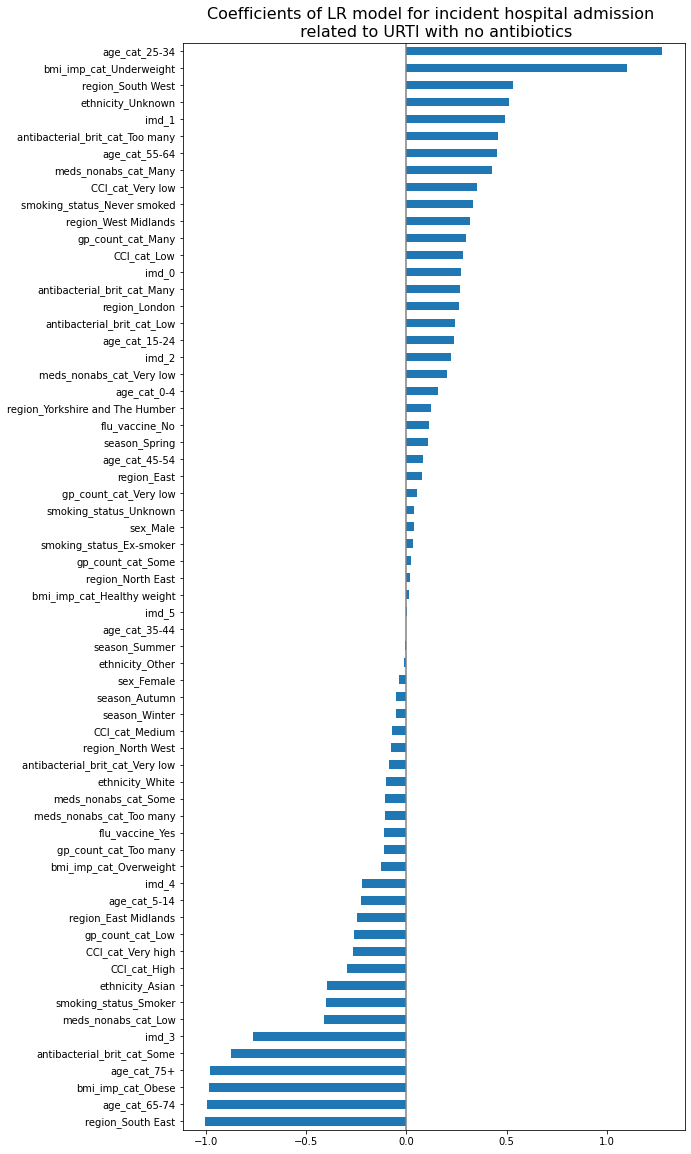

In [462]:
# feature_names = lr_urti_no_abs_incdt.feature_names_in_
# coef = np.squeeze(lr_urti_no_abs_incdt.coef_)

# coef_lr = pd.DataFrame({'Coefficients':coef}, index = feature_names)
# coef_lr = coef_lr.Coefficients.sort_values()
# # coef_lr

coef_lr.plot(kind="barh", figsize=(9, 20))
plt.title('Coefficients of LR model for incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_lr_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [463]:
a = lr_urti_no_abs_incdt.intercept_

# save 
np.savetxt('../output/hospitalisation_prediction_urti/intercept_urti_no_abs_incdt.txt', a, delimiter=',')

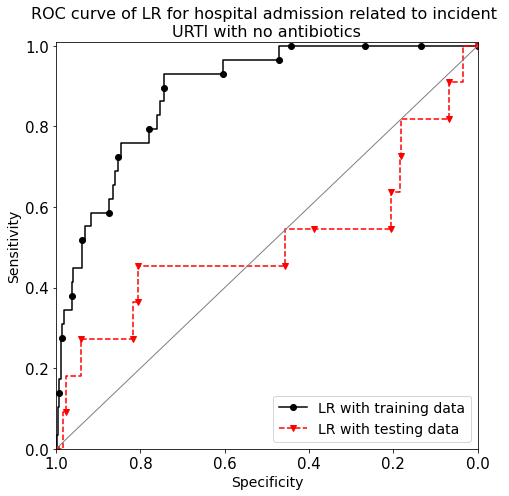

In [464]:
r_fpr1, r_tpr1, _ = roc_curve(data_urti_no_abs_incdt_lr_y_train, pred_proba_urti_no_abs_incdt_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_urti_no_abs_incdt_lr_y_test, pred_proba_urti_no_abs_incdt_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')


squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)

#plt.title('ROC Curve')
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of LR for hospital admission related to incident \nURTI with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_lr_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [465]:
r_auc1 = roc_auc_score(data_urti_no_abs_incdt_lr_y_train, pred_proba_urti_no_abs_incdt_train[:,1])
r_auc2 = roc_auc_score(data_urti_no_abs_incdt_lr_y_test, pred_proba_urti_no_abs_incdt_test[:,1])
brier1 = brier_score_loss(data_urti_no_abs_incdt_lr_y_train, pred_proba_urti_no_abs_incdt_train[:,1])
brier2 = brier_score_loss(data_urti_no_abs_incdt_lr_y_test, pred_proba_urti_no_abs_incdt_test[:,1])

print('AUROC of LR with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc1))
print('AUROC of LR with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc2))
print('Brier score of LR with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier1))
print('Brier score of LR with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier2))

AUROC of LR with training data of hospital admission related to incident URTI with no antibiotics = 0.8850
AUROC of LR with testing data of hospital admission related to incident URTI with no antibiotics = 0.5142
Brier score of LR with training data of hospital admission related to incident URTI with no antibiotics = 0.0075
Brier score of LR with testing data of hospital admission related to incident URTI with no antibiotics = 0.0089


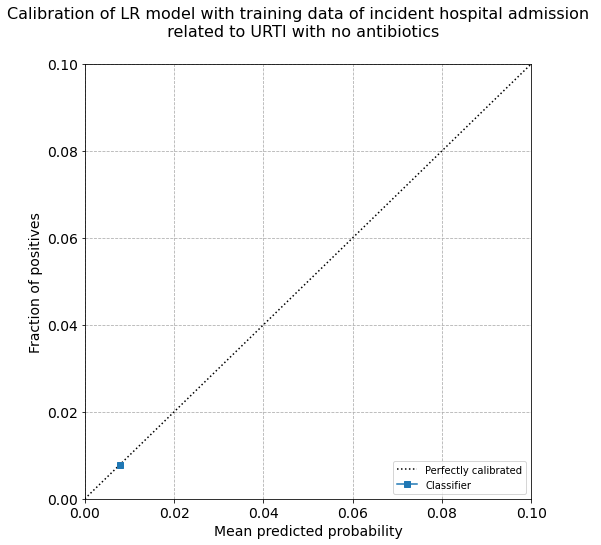

In [466]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_no_abs_incdt_train = CalibrationDisplay.from_predictions(data_urti_no_abs_incdt_lr_y_train, pred_proba_urti_no_abs_incdt_train[:,1], ax = axe)
plt.suptitle('Calibration of LR model with training data of incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_no_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

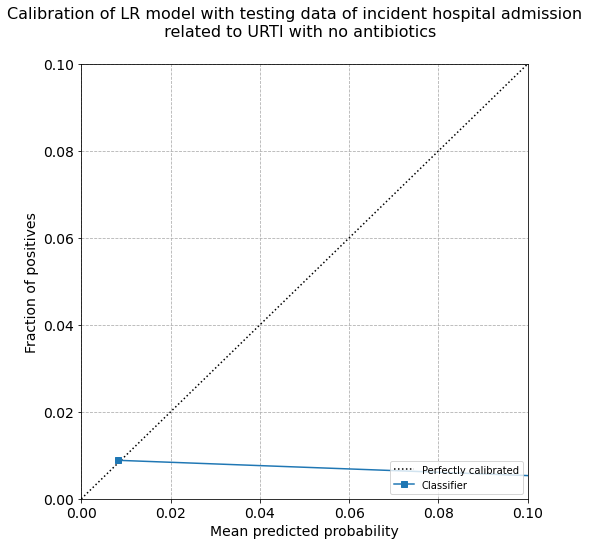

In [467]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_no_abs_incdt_train = CalibrationDisplay.from_predictions(data_urti_no_abs_incdt_lr_y_test, pred_proba_urti_no_abs_incdt_test[:,1], ax = axe)
plt.suptitle('Calibration of LR model with testing data of incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_no_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [468]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/lr_urti_no_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier2)])

### 5-1-2- Incident hospital admission related to URTI with antibiotics

In [469]:
data_urti_abs_incdt.head()

,age_cat,sex,CCI_cat,gp_count_cat,flu_vaccine,bmi_imp_cat,region,imd,ethnicity,smoking_status,season,antibacterial_brit_cat,meds_nonabs_cat,event_urti_admitted,duration_urti_admitted
3,35-44,Female,Medium,Low,No,Healthy weight,Yorkshire and The Humber,1,Asian,Unknown,Winter,Many,Very low,0.0,30.0
27,45-54,Female,Very high,Very low,No,Obese,East,2,Other,Smoker,Summer,Very low,Very low,0.0,30.0
56,75+,Male,Very high,Some,No,Obese,East Midlands,3,Other,Unknown,Winter,Very low,Very low,0.0,30.0
82,45-54,Male,Low,Low,No,Obese,South East,1,Other,Unknown,Spring,Low,Low,0.0,30.0
85,35-44,Female,High,Some,Yes,Obese,East Midlands,3,White,Unknown,Winter,Low,Very low,0.0,30.0


In [470]:
data_urti_abs_incdt.shape

(523, 15)

In [472]:
# encoding categorical data for LR

data = data_urti_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_imp_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
# passing bridge-types-cat column (label encoded values of bridge_types)
data_urti_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_imp_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat']]).toarray())
data_urti_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_imp_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat']].columns)
# data_urti_abs_incdt_enc = data.join(data_urti_abs_incdt_enc)
# data_urti_abs_incdt_enc = data_urti_abs_incdt_enc.drop(columns=['index', ])

data_urti_abs_incdt_enc.head()

,age_cat_0-4,age_cat_15-24,age_cat_25-34,age_cat_35-44,age_cat_45-54,age_cat_5-14,age_cat_55-64,age_cat_65-74,age_cat_75+,sex_Female,...,antibacterial_brit_cat_Low,antibacterial_brit_cat_Many,antibacterial_brit_cat_Some,antibacterial_brit_cat_Too many,antibacterial_brit_cat_Very low,meds_nonabs_cat_Low,meds_nonabs_cat_Many,meds_nonabs_cat_Some,meds_nonabs_cat_Too many,meds_nonabs_cat_Very low
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [473]:
data_urti_abs_incdt_enc.columns

Index(['age_cat_0-4', 'age_cat_15-24', 'age_cat_25-34', 'age_cat_35-44',
       'age_cat_45-54', 'age_cat_5-14', 'age_cat_55-64', 'age_cat_65-74',
       'age_cat_75+', 'sex_Female', 'sex_Male', 'CCI_cat_High', 'CCI_cat_Low',
       'CCI_cat_Medium', 'CCI_cat_Very high', 'CCI_cat_Very low',
       'gp_count_cat_Low', 'gp_count_cat_Many', 'gp_count_cat_Some',
       'gp_count_cat_Too many', 'gp_count_cat_Very low', 'flu_vaccine_No',
       'flu_vaccine_Yes', 'bmi_imp_cat_Healthy weight', 'bmi_imp_cat_Obese',
       'bmi_imp_cat_Overweight', 'bmi_imp_cat_Underweight', 'region_East',
       'region_East Midlands', 'region_London', 'region_North East',
       'region_North West', 'region_South East', 'region_South West',
       'region_West Midlands', 'region_Yorkshire and The Humber', 'imd_0',
       'imd_1', 'imd_2', 'imd_3', 'imd_4', 'imd_5', 'ethnicity_Asian',
       'ethnicity_Other', 'ethnicity_Unknown', 'ethnicity_White',
       'smoking_status_Ex-smoker', 'smoking_status_Never smok

In [474]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_abs_incdt_lr_X_train, data_urti_abs_incdt_lr_X_test, data_urti_abs_incdt_lr_y_train, data_urti_abs_incdt_lr_y_test = train_test_split(data_urti_abs_incdt_enc, data_urti_abs_incdt.event_urti_admitted, test_size=0.25, random_state=42)

print(f'shape of data_urti_abs_incdt_lr_X for training: {data_urti_abs_incdt_lr_X_train.shape}')
print(f'shape of data_urti_abs_incdt_lr_X for testing: {data_urti_abs_incdt_lr_X_test.shape}')
print(f'shape of data_urti_abs_incdt_lr_y for training: {data_urti_abs_incdt_lr_y_train.shape}')
print(f'shape of data_urti_abs_incdt_lr_y for testing: {data_urti_abs_incdt_lr_y_test.shape}')

shape of data_urti_abs_incdt_lr_X for training: (392, 64)
shape of data_urti_abs_incdt_lr_X for testing: (131, 64)
shape of data_urti_abs_incdt_lr_y for training: (392,)
shape of data_urti_abs_incdt_lr_y for testing: (131,)


In [475]:
#build LR model
lr_urti_abs_incdt = LogisticRegression().fit(data_urti_abs_incdt_lr_X_train, data_urti_abs_incdt_lr_y_train)

#prediction of hsopital admission related to urti of training data using lr
pred_proba_urti_abs_incdt_train = lr_urti_abs_incdt.predict_proba(data_urti_abs_incdt_lr_X_train)
# pred_proba_urti_abs_incdt_train

#calculate score of lr_urti_abs_incdt with training data
lr_urti_abs_incdt_training_score = lr_urti_abs_incdt.score(data_urti_abs_incdt_lr_X_train, data_urti_abs_incdt_lr_y_train)
print(f'score of lr_urti_abs_incdt with training data: {lr_urti_abs_incdt_training_score}')

#prediction of hsopital admission related to urti of testing data using lr
pred_proba_urti_abs_incdt_test = lr_urti_abs_incdt.predict_proba(data_urti_abs_incdt_lr_X_test)
# pred_proba_urti_abs_incdt_test

#calculate score of lr_urti_abs_incdt with testing data
lr_urti_abs_incdt_testing_score = lr_urti_abs_incdt.score(data_urti_abs_incdt_lr_X_test, data_urti_abs_incdt_lr_y_test)
print(f'score of lr_urti_abs_incdt with testing data: {lr_urti_abs_incdt_testing_score}')

score of lr_urti_abs_incdt with training data: 0.9846938775510204
score of lr_urti_abs_incdt with testing data: 0.9847328244274809


In [476]:
lr_urti_abs_incdt.coef_

array([[ 0.24377071,  0.66588036,  0.84634253,  0.33778275, -0.54988023,
        -0.39881244, -0.35771873, -0.34191925, -0.44546239, -0.11274075,
         0.11272406,  0.31177177,  0.01344101, -0.36760215,  0.07471259,
        -0.03233991,  0.13817483,  0.39550754, -0.13271779, -0.03086197,
        -0.37011929, -0.2114721 ,  0.21145541,  1.31241214, -1.01757575,
         0.03988778, -0.33474085,  0.50119352, -0.3483454 , -0.61154684,
         0.57719172,  0.29009562, -0.41157716, -0.29900814, -0.22607682,
         0.5280568 ,  0.5121238 , -0.0946237 ,  0.36013422, -0.12439726,
        -0.00492803, -0.64832571,  0.78668756, -0.30371299,  0.12994968,
        -0.61294094,  0.46735326, -0.33170599, -0.17757072,  0.04190677,
        -0.68699978, -0.2101975 ,  0.42290711,  0.47427349, -0.30279656,
        -0.17035238,  0.41841902, -0.09959029,  0.15430353, -0.3058095 ,
        -0.07139674,  0.31457066, -0.00304433,  0.06566323]])

In [477]:
lr_urti_abs_incdt.feature_names_in_

array(['age_cat_0-4', 'age_cat_15-24', 'age_cat_25-34', 'age_cat_35-44',
       'age_cat_45-54', 'age_cat_5-14', 'age_cat_55-64', 'age_cat_65-74',
       'age_cat_75+', 'sex_Female', 'sex_Male', 'CCI_cat_High',
       'CCI_cat_Low', 'CCI_cat_Medium', 'CCI_cat_Very high',
       'CCI_cat_Very low', 'gp_count_cat_Low', 'gp_count_cat_Many',
       'gp_count_cat_Some', 'gp_count_cat_Too many',
       'gp_count_cat_Very low', 'flu_vaccine_No', 'flu_vaccine_Yes',
       'bmi_imp_cat_Healthy weight', 'bmi_imp_cat_Obese',
       'bmi_imp_cat_Overweight', 'bmi_imp_cat_Underweight', 'region_East',
       'region_East Midlands', 'region_London', 'region_North East',
       'region_North West', 'region_South East', 'region_South West',
       'region_West Midlands', 'region_Yorkshire and The Humber', 'imd_0',
       'imd_1', 'imd_2', 'imd_3', 'imd_4', 'imd_5', 'ethnicity_Asian',
       'ethnicity_Other', 'ethnicity_Unknown', 'ethnicity_White',
       'smoking_status_Ex-smoker', 'smoking_status_Nev

In [478]:
feature_names = lr_urti_abs_incdt.feature_names_in_
coef = np.squeeze(lr_urti_abs_incdt.coef_)

coef_lr = pd.DataFrame({'Coefficients':coef}, index = feature_names)
coef_lr = coef_lr.Coefficients.sort_values()
# coef_lr

# save 
np.savetxt('../output/hospitalisation_prediction_urti/coef_lr_urti_abs_incdt.txt', coef_lr, delimiter=',')

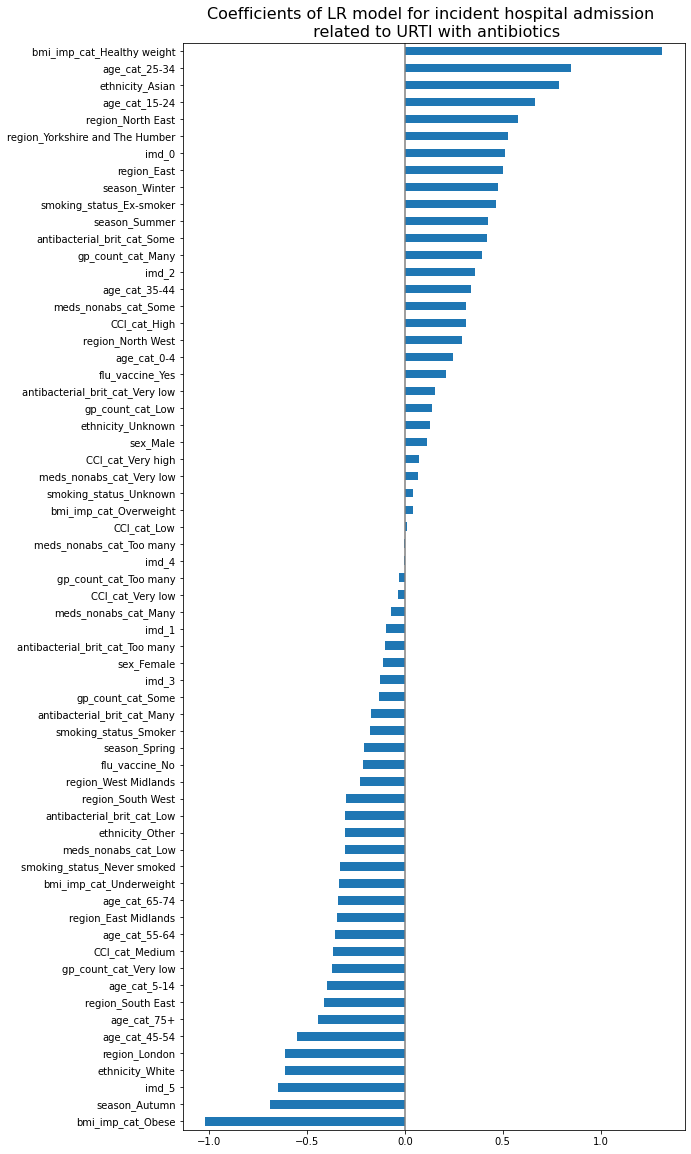

In [479]:
coef_lr.plot(kind="barh", figsize=(9, 20))
plt.title('Coefficients of LR model for incident hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_lr_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [480]:
a = lr_urti_abs_incdt.intercept_

# save 
np.savetxt('../output/hospitalisation_prediction_urti/intercept_urti_abs_incdt.txt', a, delimiter=',')

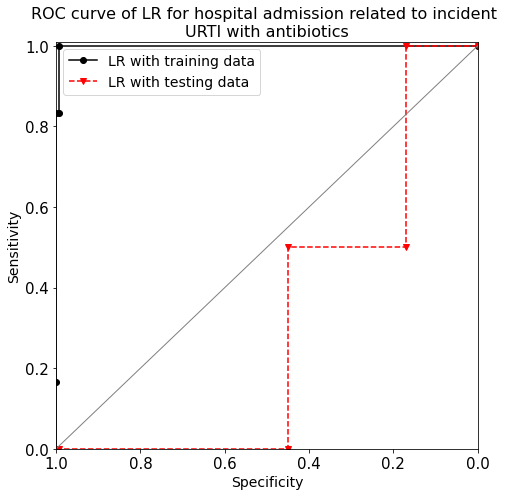

In [481]:
r_fpr1, r_tpr1, _ = roc_curve(data_urti_abs_incdt_lr_y_train, pred_proba_urti_abs_incdt_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_urti_abs_incdt_lr_y_test, pred_proba_urti_abs_incdt_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')


squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)

#plt.title('ROC Curve')
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of LR for hospital admission related to incident \nURTI with antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_lr_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [482]:
r_auc1 = roc_auc_score(data_urti_abs_incdt_lr_y_train, pred_proba_urti_abs_incdt_train[:,1])
r_auc2 = roc_auc_score(data_urti_abs_incdt_lr_y_test, pred_proba_urti_abs_incdt_test[:,1])
brier1 = brier_score_loss(data_urti_abs_incdt_lr_y_train, pred_proba_urti_abs_incdt_train[:,1])
brier2 = brier_score_loss(data_urti_abs_incdt_lr_y_test, pred_proba_urti_abs_incdt_test[:,1])

print('AUROC of LR with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc1))
print('AUROC of LR with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc2))
print('Brier score of LR with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier1))
print('Brier score of LR with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier2))

AUROC of LR with training data of hospital admission related to incident URTI with antibiotics = 0.9987
AUROC of LR with testing data of hospital admission related to incident URTI with antibiotics = 0.3101
Brier score of LR with training data of hospital admission related to incident URTI with antibiotics = 0.0097
Brier score of LR with testing data of hospital admission related to incident URTI with antibiotics = 0.0175


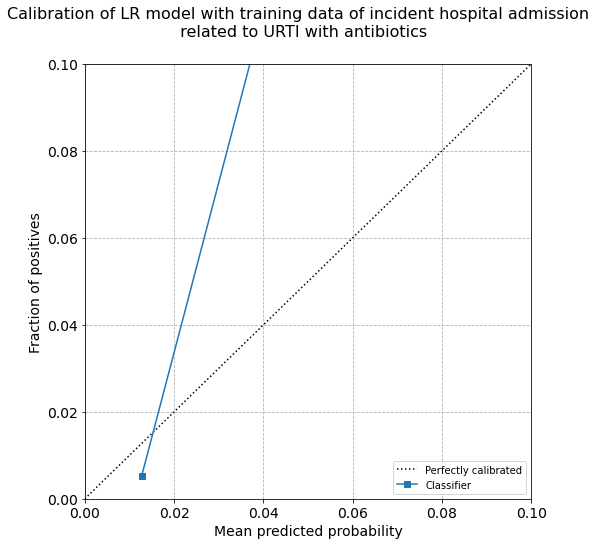

In [483]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_abs_incdt_train = CalibrationDisplay.from_predictions(data_urti_abs_incdt_lr_y_train, pred_proba_urti_abs_incdt_train[:,1], ax = axe)
plt.suptitle('Calibration of LR model with training data of incident hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

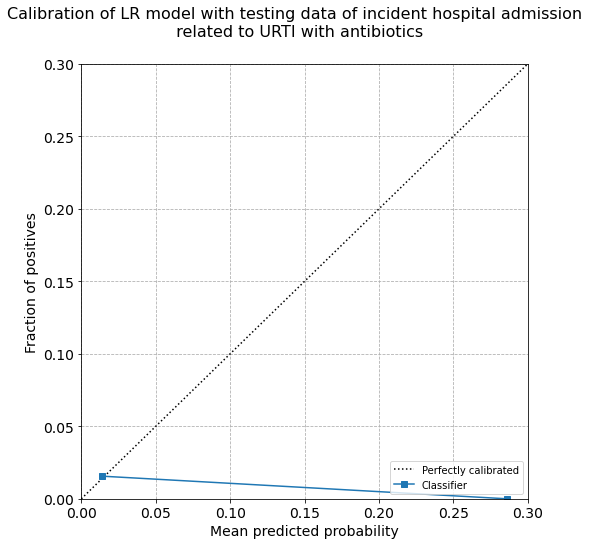

In [486]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_abs_incdt_train = CalibrationDisplay.from_predictions(data_urti_abs_incdt_lr_y_test, pred_proba_urti_abs_incdt_test[:,1], ax = axe)
plt.suptitle('Calibration of LR model with testing data of incident hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [487]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/lr_urti_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier2)])

### 5-1-3- Prevalent hospital admission related to URTI with no antibiotics

In [488]:
data_urti_no_abs_prevl.head()

,age_cat,sex,CCI_cat,gp_count_cat,flu_vaccine,bmi_imp_cat,region,imd,ethnicity,smoking_status,season,antibacterial_brit_cat,meds_nonabs_cat,event_urti_admitted,duration_urti_admitted
5,15-24,Male,Very low,Low,No,Obese,North East,2,Other,Smoker,Spring,Very low,Many,0.0,30.0
8,25-34,Female,Very low,Very low,No,Overweight,East,2,Unknown,Unknown,Spring,Very low,Very low,0.0,30.0
39,45-54,Female,Very low,Very low,No,Obese,North West,2,Unknown,Never smoked,Spring,Low,Very low,0.0,30.0
68,0-4,Female,Very low,Very low,No,Overweight,East Midlands,1,White,Smoker,Autumn,Very low,Low,0.0,30.0
86,5-14,Female,Very low,Very low,No,Obese,West Midlands,5,Asian,Smoker,Winter,Very low,Very low,0.0,30.0


In [489]:
data_urti_no_abs_prevl.shape

(540, 15)

In [490]:
# encoding categorical data for LR

data = data_urti_no_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_imp_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
# passing bridge-types-cat column (label encoded values of bridge_types)
data_urti_no_abs_prevl_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_imp_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat']]).toarray())
data_urti_no_abs_prevl_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_imp_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat']].columns)
# data_urti_no_abs_prevl_enc = data.join(data_urti_no_abs_prevl_enc)
# data_urti_no_abs_prevl_enc = data_urti_no_abs_prevl_enc.drop(columns=['index', ])

data_urti_no_abs_prevl_enc.head()

,age_cat_0-4,age_cat_15-24,age_cat_25-34,age_cat_35-44,age_cat_45-54,age_cat_5-14,age_cat_55-64,age_cat_65-74,age_cat_75+,sex_Female,...,antibacterial_brit_cat_Low,antibacterial_brit_cat_Many,antibacterial_brit_cat_Some,antibacterial_brit_cat_Too many,antibacterial_brit_cat_Very low,meds_nonabs_cat_Low,meds_nonabs_cat_Many,meds_nonabs_cat_Some,meds_nonabs_cat_Too many,meds_nonabs_cat_Very low
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [491]:
data_urti_no_abs_prevl_enc.columns

Index(['age_cat_0-4', 'age_cat_15-24', 'age_cat_25-34', 'age_cat_35-44',
       'age_cat_45-54', 'age_cat_5-14', 'age_cat_55-64', 'age_cat_65-74',
       'age_cat_75+', 'sex_Female', 'sex_Male', 'CCI_cat_High', 'CCI_cat_Low',
       'CCI_cat_Medium', 'CCI_cat_Very high', 'CCI_cat_Very low',
       'gp_count_cat_Low', 'gp_count_cat_Many', 'gp_count_cat_Some',
       'gp_count_cat_Too many', 'gp_count_cat_Very low', 'flu_vaccine_No',
       'flu_vaccine_Yes', 'bmi_imp_cat_Healthy weight', 'bmi_imp_cat_Obese',
       'bmi_imp_cat_Overweight', 'bmi_imp_cat_Underweight', 'region_East',
       'region_East Midlands', 'region_London', 'region_North East',
       'region_North West', 'region_South East', 'region_South West',
       'region_West Midlands', 'region_Yorkshire and The Humber', 'imd_0',
       'imd_1', 'imd_2', 'imd_3', 'imd_4', 'imd_5', 'ethnicity_Asian',
       'ethnicity_Other', 'ethnicity_Unknown', 'ethnicity_White',
       'smoking_status_Ex-smoker', 'smoking_status_Never smok

In [492]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_prevl_lr_X_train, data_urti_no_abs_prevl_lr_X_test, data_urti_no_abs_prevl_lr_y_train, data_urti_no_abs_prevl_lr_y_test = train_test_split(data_urti_no_abs_prevl_enc, data_urti_no_abs_prevl.event_urti_admitted, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_prevl_lr_X for training: {data_urti_no_abs_prevl_lr_X_train.shape}')
print(f'shape of data_urti_no_abs_prevl_lr_X for testing: {data_urti_no_abs_prevl_lr_X_test.shape}')
print(f'shape of data_urti_no_abs_prevl_lr_y for training: {data_urti_no_abs_prevl_lr_y_train.shape}')
print(f'shape of data_urti_no_abs_prevl_lr_y for testing: {data_urti_no_abs_prevl_lr_y_test.shape}')

shape of data_urti_no_abs_prevl_lr_X for training: (405, 64)
shape of data_urti_no_abs_prevl_lr_X for testing: (135, 64)
shape of data_urti_no_abs_prevl_lr_y for training: (405,)
shape of data_urti_no_abs_prevl_lr_y for testing: (135,)


In [493]:
#build LR model
lr_urti_no_abs_prevl = LogisticRegression().fit(data_urti_no_abs_prevl_lr_X_train, data_urti_no_abs_prevl_lr_y_train)

#prediction of hsopital admission related to urti of training data using lr
pred_proba_urti_no_abs_prevl_train = lr_urti_no_abs_prevl.predict_proba(data_urti_no_abs_prevl_lr_X_train)
# pred_proba_urti_no_abs_prevl_train

#calculate score of lr_urti_no_abs_prevl with training data
lr_urti_no_abs_prevl_training_score = lr_urti_no_abs_prevl.score(data_urti_no_abs_prevl_lr_X_train, data_urti_no_abs_prevl_lr_y_train)
print(f'score of lr_urti_no_abs_prevl with training data: {lr_urti_no_abs_prevl_training_score}')

#prediction of hsopital admission related to urti of testing data using lr
pred_proba_urti_no_abs_prevl_test = lr_urti_no_abs_prevl.predict_proba(data_urti_no_abs_prevl_lr_X_test)
# pred_proba_urti_no_abs_prevl_test

#calculate score of lr_urti_no_abs_prevl with testing data
lr_urti_no_abs_prevl_testing_score = lr_urti_no_abs_prevl.score(data_urti_no_abs_prevl_lr_X_test, data_urti_no_abs_prevl_lr_y_test)
print(f'score of lr_urti_no_abs_prevl with testing data: {lr_urti_no_abs_prevl_testing_score}')

score of lr_urti_no_abs_prevl with training data: 0.9950617283950617
score of lr_urti_no_abs_prevl with testing data: 1.0


In [494]:
lr_urti_no_abs_prevl.coef_

array([[-0.1369711 ,  0.41019918, -0.14171454,  0.57589494, -0.10411875,
        -0.15918319, -0.16035756, -0.12230283, -0.16143452,  0.07978114,
        -0.07976951, -0.0453854 , -0.14295974, -0.1453321 ,  0.63468589,
        -0.30099703, -0.23254242, -0.04294392, -0.17393118, -0.00209511,
         0.45152427,  0.10996773, -0.1099561 , -0.09281585, -0.25302018,
        -0.20130614,  0.54715381, -0.14476515, -0.13321799, -0.18552726,
        -0.12535692, -0.12468182, -0.11966071, -0.10195438,  1.02498959,
        -0.08981374, -0.04481904,  0.44528885,  0.17272981, -0.18724489,
        -0.19008682, -0.19585628,  0.51023469,  0.44087473, -0.36811488,
        -0.58298291, -0.07210079,  0.38407953, -0.40887949,  0.09691237,
         0.82649116, -0.29261388, -0.22767063, -0.30619502, -0.24132449,
        -0.10050896,  0.31829514, -0.00499585,  0.02854579, -0.0967857 ,
        -0.02224721, -0.08661544, -0.00263363,  0.20829361]])

In [495]:
lr_urti_no_abs_prevl.feature_names_in_

array(['age_cat_0-4', 'age_cat_15-24', 'age_cat_25-34', 'age_cat_35-44',
       'age_cat_45-54', 'age_cat_5-14', 'age_cat_55-64', 'age_cat_65-74',
       'age_cat_75+', 'sex_Female', 'sex_Male', 'CCI_cat_High',
       'CCI_cat_Low', 'CCI_cat_Medium', 'CCI_cat_Very high',
       'CCI_cat_Very low', 'gp_count_cat_Low', 'gp_count_cat_Many',
       'gp_count_cat_Some', 'gp_count_cat_Too many',
       'gp_count_cat_Very low', 'flu_vaccine_No', 'flu_vaccine_Yes',
       'bmi_imp_cat_Healthy weight', 'bmi_imp_cat_Obese',
       'bmi_imp_cat_Overweight', 'bmi_imp_cat_Underweight', 'region_East',
       'region_East Midlands', 'region_London', 'region_North East',
       'region_North West', 'region_South East', 'region_South West',
       'region_West Midlands', 'region_Yorkshire and The Humber', 'imd_0',
       'imd_1', 'imd_2', 'imd_3', 'imd_4', 'imd_5', 'ethnicity_Asian',
       'ethnicity_Other', 'ethnicity_Unknown', 'ethnicity_White',
       'smoking_status_Ex-smoker', 'smoking_status_Nev

In [496]:
feature_names = lr_urti_no_abs_prevl.feature_names_in_
coef = np.squeeze(lr_urti_no_abs_prevl.coef_)

coef_lr = pd.DataFrame({'Coefficients':coef}, index = feature_names)
coef_lr = coef_lr.Coefficients.sort_values()
# coef_lr

# save 
np.savetxt('../output/hospitalisation_prediction_urti/coef_lr_urti_no_abs_prevl.txt', coef_lr, delimiter=',')

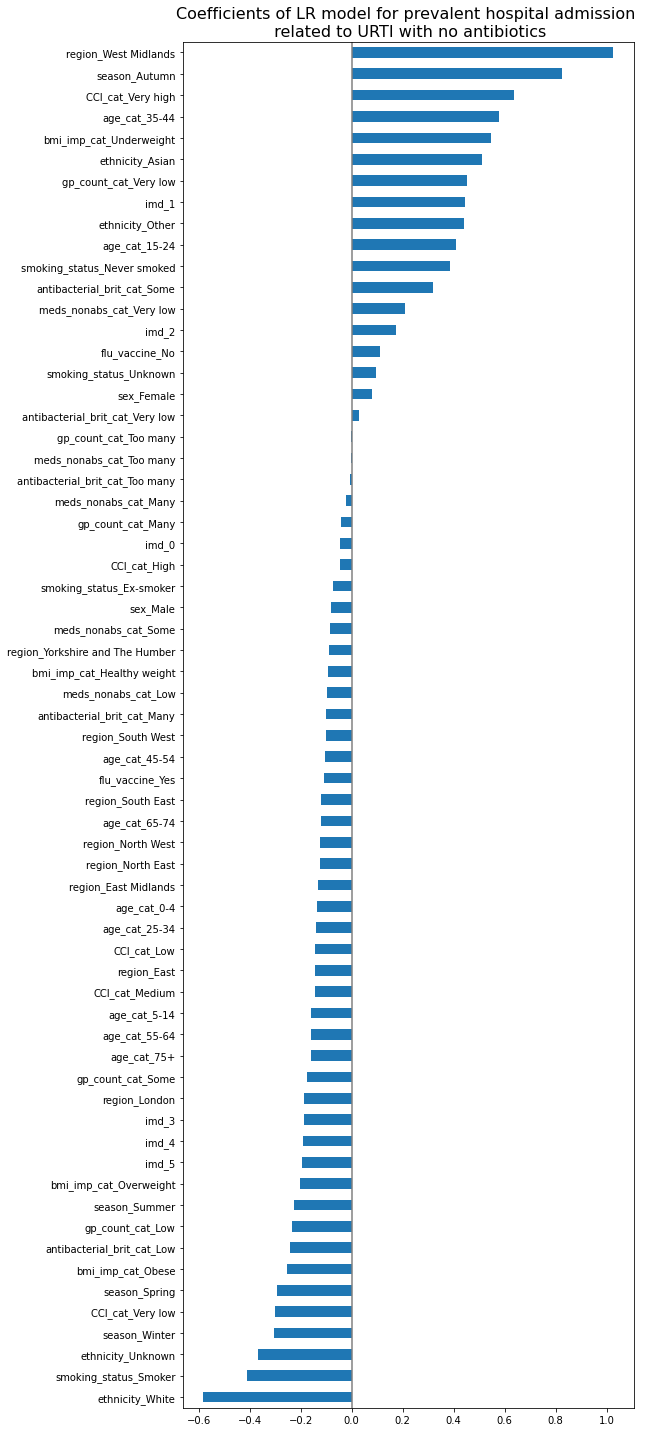

In [497]:
coef_lr.plot(kind="barh", figsize=(9, 20))
plt.title('Coefficients of LR model for prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_lr_urti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()


In [498]:
a = lr_urti_no_abs_prevl.intercept_

# save 
np.savetxt('../output/hospitalisation_prediction_urti/intercept_urti_no_abs_prevl.txt', a, delimiter=',')

In [500]:
r_fpr1, r_tpr1, _ = roc_curve(data_urti_no_abs_prevl_lr_y_train, pred_proba_urti_no_abs_prevl_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_urti_no_abs_prevl_lr_y_test, pred_proba_urti_no_abs_prevl_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')


squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)

#plt.title('ROC Curve')
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of LR for hospital admission related to prevalent \nURTI with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_lr_urti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [250]:
r_auc1 = roc_auc_score(data_urti_no_abs_prevl_lr_y_train, pred_proba_urti_no_abs_prevl_train[:,1])
r_auc2 = roc_auc_score(data_urti_no_abs_prevl_lr_y_test, pred_proba_urti_no_abs_prevl_test[:,1])
brier1 = brier_score_loss(data_urti_no_abs_prevl_lr_y_train, pred_proba_urti_no_abs_prevl_train[:,1])
brier2 = brier_score_loss(data_urti_no_abs_prevl_lr_y_test, pred_proba_urti_no_abs_prevl_test[:,1])

print('AUROC of LR with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc1))
print('AUROC of LR with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc2))
print('Brier score of LR with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier1))
print('Brier score of LR with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier2))

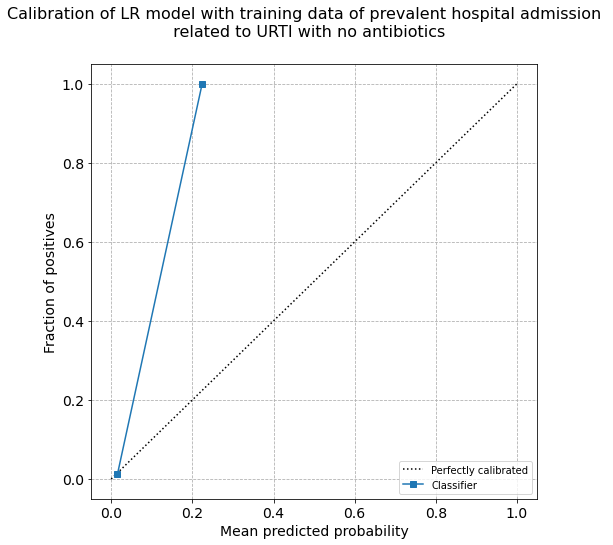

In [251]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_no_abs_prevl_train = CalibrationDisplay.from_predictions(data_urti_no_abs_prevl_lr_y_train, pred_proba_urti_no_abs_prevl_train[:,1], ax = axe)
plt.suptitle('Calibration of LR model with training data of prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_no_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_no_abs_prevl_train = CalibrationDisplay.from_predictions(data_urti_no_abs_prevl_lr_y_test, pred_proba_urti_no_abs_prevl_test[:,1], ax = axe)
plt.suptitle('Calibration of LR model with testing data of prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_no_abs_prevl_test.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/lr_urti_no_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier2)])